In [1]:
#!pip install lightgbm

In [29]:
import pandas as pd
import numpy as np
import pyod
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from pyod.utils.data import evaluate_print

from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.models.lof import LOF 
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD

from pyod.models.abod import ABOD
from pyod.models.sos import SOS

from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lscp import LSCP

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

from sklearn.preprocessing import StandardScaler
from feature_selector import FeatureSelector

from datetime import datetime
np.set_printoptions(precision=3)

In [30]:
testing_set = pd.read_csv('../Unbalanced_Samples/Sample_60K.csv',sep=',',header=0)

import csv
with open('../Unbalanced_Samples/Sample_60K.csv', newline='') as f:
  csv_reader = csv.reader(f)
  header = next(csv_reader)

for i in range(len(header)):
    header[i] = header[i]+" ("+str(i)+")"
print(header)

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0 (0)', 'Flow ID (1)', 'Src IP (2)', 'Src Port (3)', 'Dst IP (4)', 'Dst Port (5)', 'Protocol (6)', 'Timestamp (7)', 'Flow Duration (8)', 'Tot Fwd Pkts (9)', 'Tot Bwd Pkts (10)', 'TotLen Fwd Pkts (11)', 'TotLen Bwd Pkts (12)', 'Fwd Pkt Len Max (13)', 'Fwd Pkt Len Min (14)', 'Fwd Pkt Len Mean (15)', 'Fwd Pkt Len Std (16)', 'Bwd Pkt Len Max (17)', 'Bwd Pkt Len Min (18)', 'Bwd Pkt Len Mean (19)', 'Bwd Pkt Len Std (20)', 'Flow Byts/s (21)', 'Flow Pkts/s (22)', 'Flow IAT Mean (23)', 'Flow IAT Std (24)', 'Flow IAT Max (25)', 'Flow IAT Min (26)', 'Fwd IAT Tot (27)', 'Fwd IAT Mean (28)', 'Fwd IAT Std (29)', 'Fwd IAT Max (30)', 'Fwd IAT Min (31)', 'Bwd IAT Tot (32)', 'Bwd IAT Mean (33)', 'Bwd IAT Std (34)', 'Bwd IAT Max (35)', 'Bwd IAT Min (36)', 'Fwd PSH Flags (37)', 'Bwd PSH Flags (38)', 'Fwd URG Flags (39)', 'Bwd URG Flags (40)', 'Fwd Header Len (41)', 'Bwd Header Len (42)', 'Fwd Pkts/s (43)', 'Bwd Pkts/s (44)', 'Pkt Len Min (45)', 'Pkt Len Max (46)', 'Pkt Len Mean (47)', 'Pkt Len 

In [31]:
#transforma dados categóricos em números
for f in testing_set.columns: 
    if testing_set[f].dtype=='object': 
        label = preprocessing.LabelEncoder() 
        label.fit(list(testing_set[f].values)) 
        testing_set[f] = label.transform(list(testing_set[f].values))
    
testingSet = testing_set.values
np.random.shuffle(testingSet)

testingSet = testingSet.astype(float)

for i in range (testingSet.shape[0]-1, 0, -1):
    for j in range(0, testingSet.shape[1]):
        testingSet[i, j] = float(testingSet[i, j])
        if (np.isinf(testingSet[i, j]) or np.isnan(testingSet[i, j])):
            testingSet = np.delete(testingSet, i, axis=0)

y_test = testingSet[:, 84].astype(int)

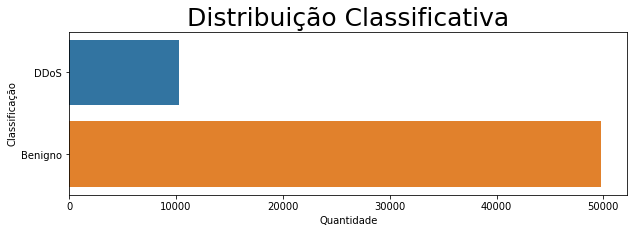

In [32]:
pyplot.subplots(figsize=(10, 3))
distribution = pd.DataFrame({"Classificação": ["DDoS","Benigno"],
                             "Quantidade":  [y_test.sum() , y_test.size - y_test.sum()]})
sns.barplot(data=distribution, y="Classificação", x="Quantidade").set_title("Distribuição Classificativa", fontsize=25)
pyplot.show()

In [33]:
#salva os sets originais
original_testingSet = testingSet
original_testingSet = np.delete(original_testingSet, 84, axis=1)
original_header = header
original_header = np.delete(original_header, 84, axis=0)

In [34]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index

In [35]:
#Features codificadas pelo label enconder: 17 16 7 4 2 1 0
#Feaatures sempre 0: 67, 66, 65, 64, 63, 62, 40, 39
#features com correlação próxima de zero, vide loop abaixo: 73, 71, 70, 50, 42, 34, 12, 10 

droppingList = [67, 66, 65, 64, 63, 62, 40, 39]
droppedFeatures = droppingList

#cm = testing_set[top_corr_features].corr().values
for i in (droppingList):
    testingSet = np.delete(testingSet, i, axis=1)
    header = np.delete(header, i, axis=0)
    
#    cm = np.delete(cm, i, axis = 0)
#    cm = np.delete(cm, i, axis = 1)

#tolerance = 0.4
#for i in range(cm.shape[0]-1, 0, -1):
#    if cm[cm.shape[0]-1, i] >= -tolerance and cm[cm.shape[0]-1, i] <= tolerance:
#        if i not in droppingList:
#            droppedFeatures.append(i)
#            testingSet = np.delete(testingSet, i, axis=1)
#            header = np.delete(header, i, axis=0)
print("Features dropadas: ")
print(droppedFeatures)

Features dropadas: 
[67, 66, 65, 64, 63, 62, 40, 39]


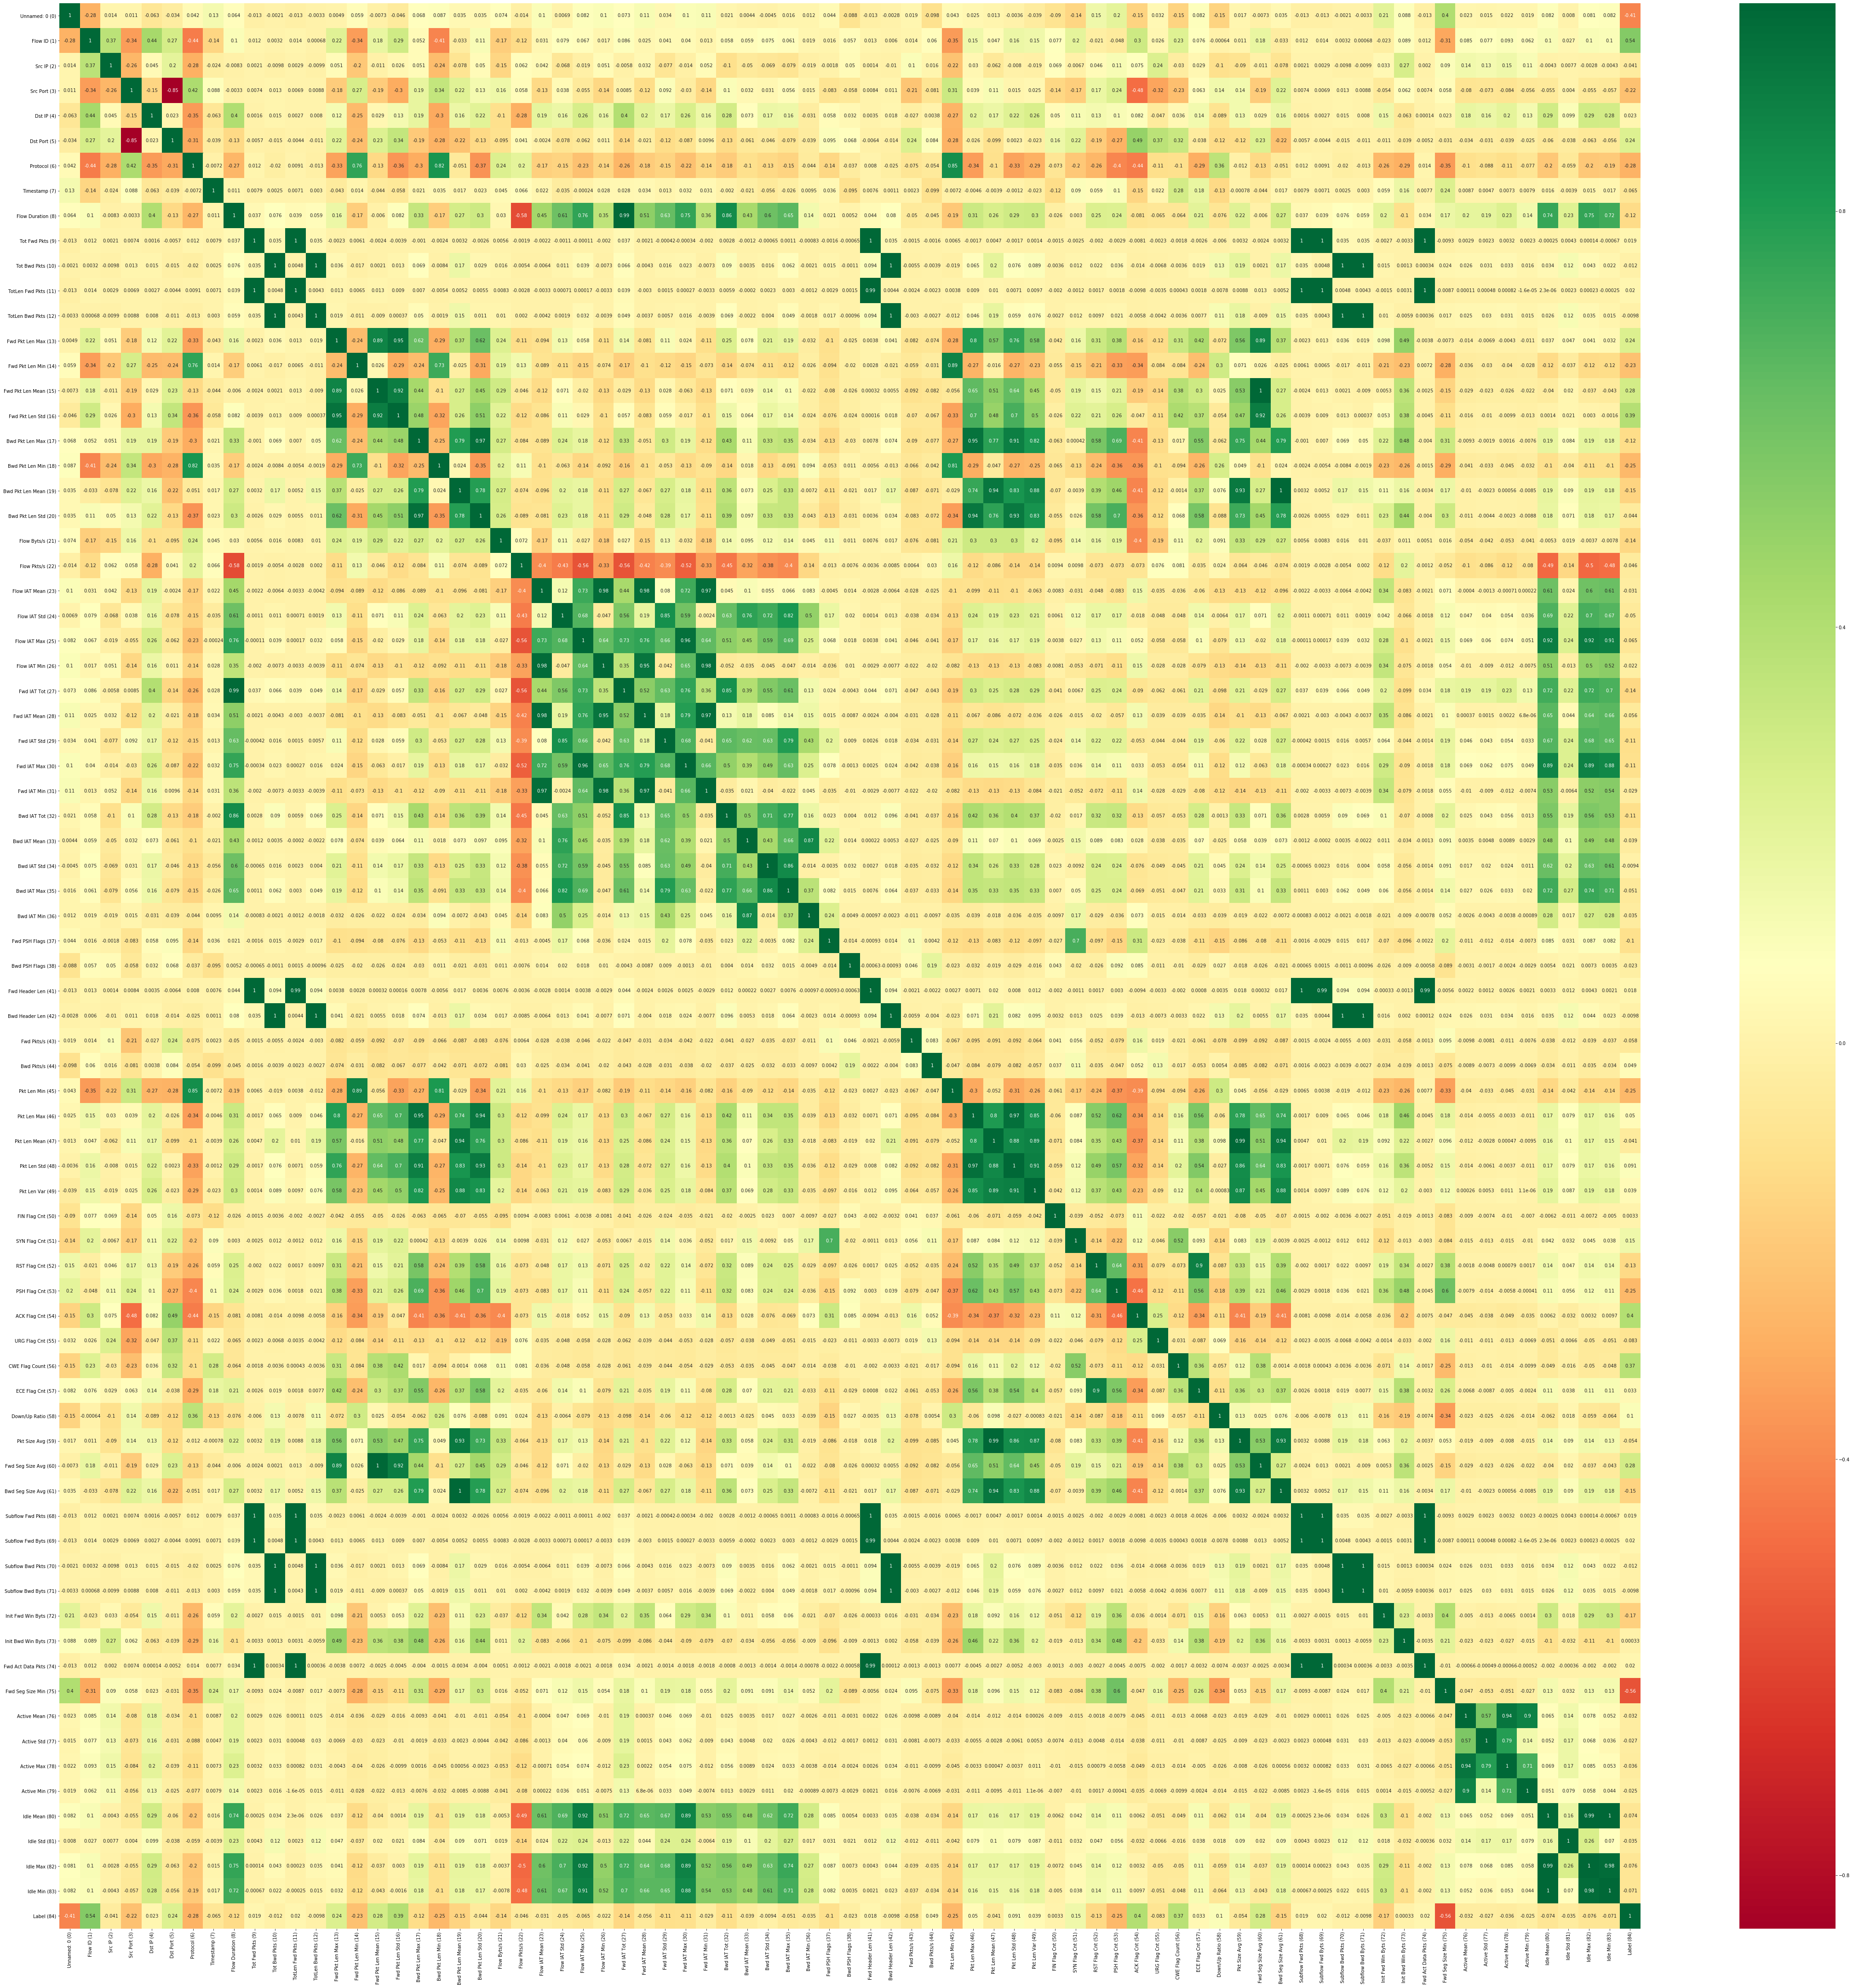

In [19]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(testingSet.shape[1], testingSet.shape[1]))
#plot heat map
g=sns.heatmap(testing_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)

testingSet = np.delete(testingSet, 84-len(droppedFeatures), axis=1)  #deleta o label
header = np.delete(header, 84-len(droppedFeatures), axis=0)

labelCorrelation_testingSet = testingSet
labelCorrelation_header = header

In [20]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
fs = FeatureSelector(data = testing_set, labels = y_test)
fs.identify_collinear(correlation_threshold = 0.7)

#gets real indexes of collinear above threshold features
real_indexs = np.zeros(fs.record_collinear.shape[0])
j = 0
for i in range(header.size):
    if (header[i] == fs.record_collinear.iloc[j, 0]):
        real_indexs[j] = i
        j = j+1

real_indexs = np.unique(real_indexs)
for i in range(real_indexs.size - 1, -1, -1):
    np.delete(testingSet, real_indexs[i], axis = 1)

print(real_indexs)
fs.record_collinear.head()

43 features with a correlation magnitude greater than 0.70.



C:\Users\andre\Anaconda3\envs\security\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


[ 0.  5. 11. 12. 14. 15. 16.]


drop_feature          corr_feature  corr_value
0           Dst Port (5)          Src Port (3)   -0.851178
1   TotLen Fwd Pkts (11)      Tot Fwd Pkts (9)    0.998565
2   TotLen Bwd Pkts (12)     Tot Bwd Pkts (10)    0.999059
3   Fwd Pkt Len Min (14)          Protocol (6)    0.758172
4  Fwd Pkt Len Mean (15)  Fwd Pkt Len Max (13)    0.888610

In [21]:
testingSet.shape

(60000, 76)

In [22]:
#Aplica a padronização z-score
"""testingSetSaved = testingSet

mi = np.mean(testingSet)
sigma = np.std(testingSet)
testingSet = (testingSet - mi) / sigma"""

#Aplica regularização default sk-learn
scaler = StandardScaler()
scaler.fit_transform(testingSet)

array([[ 0.111,  0.324,  0.986, ..., -0.093, -0.294, -0.283],
       [-1.393,  1.062, -0.064, ..., -0.093, -0.294, -0.283],
       [-0.616,  0.979, -0.246, ..., -0.093, -0.294, -0.283],
       ...,
       [-0.146,  0.116, -1.293, ..., -0.093, -0.294, -0.283],
       [ 1.358,  0.294, -0.18 , ..., -0.093, -0.294, -0.283],
       [-0.447, -0.179,  1.467, ..., -0.093, -0.294, -0.283]])

In [23]:
outliers_fraction = 0.17
def testMethod(clf, clf_name):
    start_fit = datetime.now()
    clf.fit(testingSet)

    #####################################################################
    
    y_test_pred = clf.predict(testingSet)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(testingSet)  # outlier scores
    end_predict = datetime.now()
    
    #####################################################################

    print("\nResults - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(y_test.size):
        if(y_test[i] == 1 and y_test_pred[i] == 1):
            truePositive = truePositive+1
        elif (y_test[i] == 0 and y_test_pred[i] == 0):
            trueNegative = trueNegative+1
        elif (y_test[i] == 0 and y_test_pred[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print("Confusion Matrix:")
    print("               Actual")
    print("Predicted  ", truePositive, " | ", falsePositive)
    print("           ",falseNegative, " | ", trueNegative,"\n")

    evaluate_print(clf_name, y_test, y_test_scores)

    #####################################################################

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_scores)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic - '+clf_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    #gets usual metrics based on results obtained
    total = y_test.shape[0]
    
    accuracy = (truePositive+trueNegative)/total
    print("Accuracy: ", accuracy)
    
    if(truePositive+falsePositive != 0):
        precision = truePositive/(truePositive+falsePositive)
        print("Precision: ", precision)
    else:
        precision = 0
        print("Precision: -")
        
    if(truePositive+falseNegative != 0):
        recall = truePositive/(truePositive+falseNegative)
        print("Recall: ", recall)
    else:
        recall = 0
        print("Recall: -")
        
    if(recall + precision != 0):
        f1 = 2*(recall*precision)/(recall+precision)
        print("F1-score: ", f1)
    else:
        print("F1-score: -")
        
    duration = end_predict - start_fit
    print("Duration: ", duration.total_seconds(), " seconds")
    print("\n")


Results - PCA:
Confusion Matrix:
               Actual
Predicted   2170  |  8030
            8086  |  41714 

PCA ROC:0.5791, precision @ rank n:0.2124


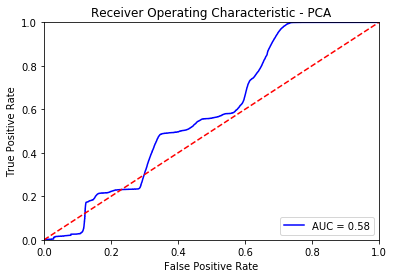

Accuracy:  0.7314
Precision:  0.21274509803921568
Recall:  0.21158346333853353
F1-score:  0.2121626906531091
Duration:  2.701337  seconds



Results - MCD:
Confusion Matrix:
               Actual
Predicted   792  |  9408
            9464  |  40336 

MCD ROC:0.4616, precision @ rank n:0.0772


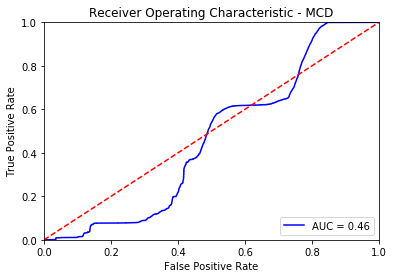

Accuracy:  0.6854666666666667
Precision:  0.07764705882352942
Recall:  0.07722308892355695
F1-score:  0.07743449354712555
Duration:  49.530065  seconds



Results - OCSVM:
Confusion Matrix:
               Actual
Predicted   0  |  0
            10256  |  49744 

OCSVM ROC:0.4996, precision @ rank n:0.0


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


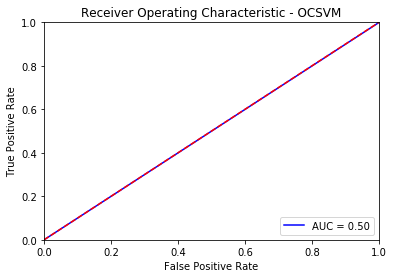

Accuracy:  0.8290666666666666
Precision: -
Recall:  0.0
F1-score: -
Duration:  2553.583764  seconds




In [24]:
#Linear Models
classifiers = {
    'PCA': PCA(contamination= outliers_fraction),
    'MCD': MCD(contamination= outliers_fraction),
    'OCSVM': OCSVM(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)


Results - LOF:
Confusion Matrix:
               Actual
Predicted   819  |  8361
            9437  |  41383 

LOF ROC:0.4188, precision @ rank n:0.0883


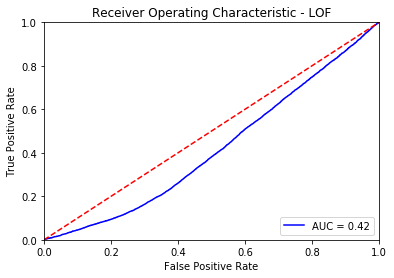

Accuracy:  0.7033666666666667
Precision:  0.0892156862745098
Recall:  0.07985569422776911
F1-score:  0.08427660012348219
Duration:  67.216918  seconds



Results - CBLOF:
Confusion Matrix:
               Actual
Predicted   1336  |  8864
            8920  |  40880 

CBLOF ROC:0.6092, precision @ rank n:0.1349


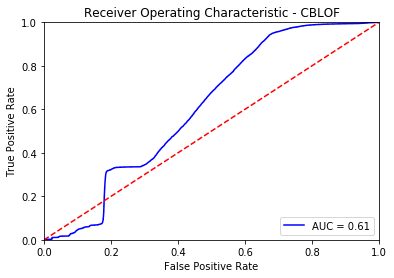

Accuracy:  0.7036
Precision:  0.13098039215686275
Recall:  0.13026521060842433
F1-score:  0.13062182244818146
Duration:  11.021137  seconds



Results - HBOS:
Confusion Matrix:
               Actual
Predicted   1828  |  8372
            8428  |  41372 

HBOS ROC:0.66, precision @ rank n:0.1782


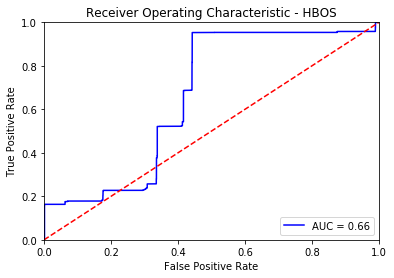

Accuracy:  0.72
Precision:  0.17921568627450982
Recall:  0.17823712948517942
F1-score:  0.17872506843957764
Duration:  3.487682  seconds



Results - kNN:
Confusion Matrix:
               Actual
Predicted   651  |  9015
            9605  |  40729 

kNN ROC:0.3629, precision @ rank n:0.0716


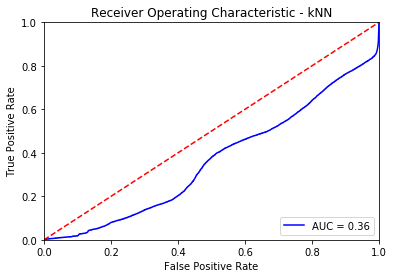

Accuracy:  0.6896666666666667
Precision:  0.06734947237740534
Recall:  0.06347503900156007
F1-score:  0.06535488404778637
Duration:  239.773726  seconds



Results - AvgKNN:
Confusion Matrix:
               Actual
Predicted   499  |  7952
            9757  |  41792 

AvgKNN ROC:0.3569, precision @ rank n:0.0683


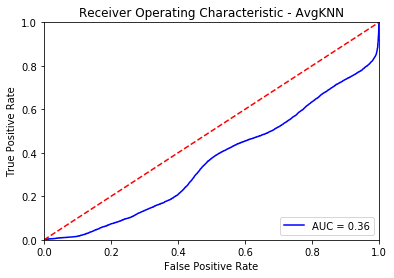

Accuracy:  0.70485
Precision:  0.05904626671399835
Recall:  0.048654446177847116
F1-score:  0.053349013738172885
Duration:  247.115739  seconds



Results - MedKNN:
Confusion Matrix:
               Actual
Predicted   609  |  8590
            9647  |  41154 

MedKNN ROC:0.3553, precision @ rank n:0.0667


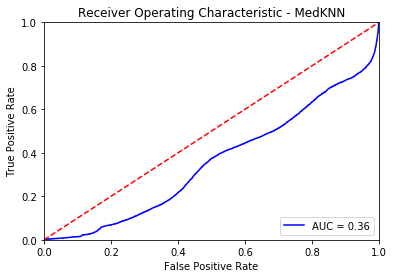

Accuracy:  0.69605
Precision:  0.06620284813566692
Recall:  0.0593798751950078
F1-score:  0.0626060138781804
Duration:  260.612955  seconds



Results - SOD:
Confusion Matrix:
               Actual
Predicted   452  |  9748
            9804  |  39996 

SOD ROC:0.3841, precision @ rank n:0.0444


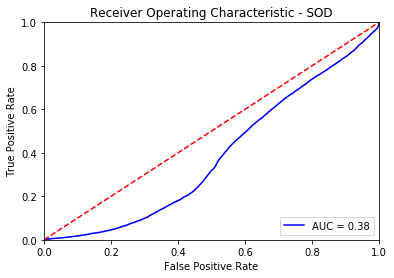

Accuracy:  0.6741333333333334
Precision:  0.044313725490196076
Recall:  0.04407176287051482
F1-score:  0.04419241298396558
Duration:  9374.559216  seconds




In [25]:
#Proximity Based
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  #Apresentou erros de execução.
    'LOF': LOF(contamination = outliers_fraction),
    'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   #Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'kNN': KNN(method='largest', contamination= outliers_fraction),
    'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    'MedKNN': KNN(method='median', contamination= outliers_fraction),
    'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)    


Results - ABOD:
Confusion Matrix:
               Actual
Predicted   574  |  9648
            9682  |  40096 

ABOD ROC:0.3426, precision @ rank n:0.0564


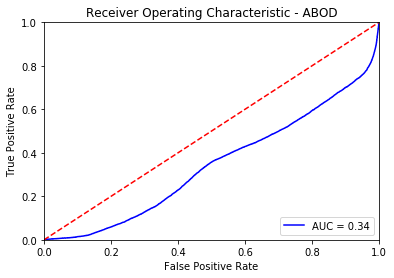

Accuracy:  0.6778333333333333
Precision:  0.05615339463901389
Recall:  0.05596723868954758
F1-score:  0.056060162125207535
Duration:  115.702405  seconds




In [26]:
#Probabilistic tests
classifiers = {
    'ABOD': ABOD(contamination = outliers_fraction),
    #'SOS': SOS(contamination = outliers_fraction) #Apresentou erros de execução.
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)



Results - Isolation Forest:
Confusion Matrix:
               Actual
Predicted   1689  |  8511
            8567  |  41233 

Isolation Forest ROC:0.486, precision @ rank n:0.1663


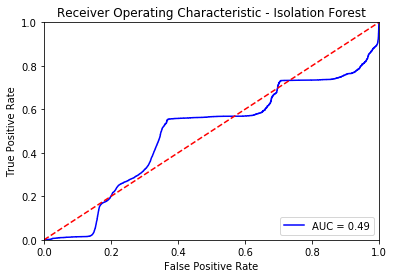

Accuracy:  0.7153666666666667
Precision:  0.16558823529411765
Recall:  0.16468408736349455
F1-score:  0.16513492373875635
Duration:  37.278131  seconds



Results - Feature Bagging:
Confusion Matrix:
               Actual
Predicted   829  |  8341
            9427  |  41403 

Feature Bagging ROC:0.3924, precision @ rank n:0.0916


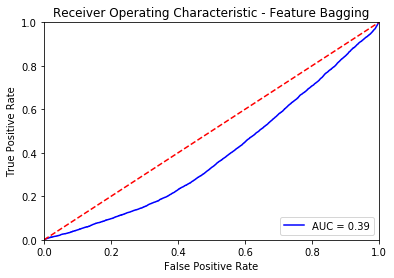

Accuracy:  0.7038666666666666
Precision:  0.09040348964013085
Recall:  0.08083073322932917
F1-score:  0.08534953155564706
Duration:  732.553624  seconds




In [27]:
#Ensenbles tests
listDetectors = detector_list=[HBOS(),
                               PCA(),
                               ABOD(),
                               LOF(),
                               KNN()]
classifiers = {
    'Isolation Forest': IForest(contamination = outliers_fraction),
    'Feature Bagging': FeatureBagging(contamination = outliers_fraction)
    #'LSCP': LSCP(detector_list = listDetectors, contamination = outliers_fraction) #Still couldn't get it to work
    #XGBOD tests are in a separate file
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)

W1101 23:05:47.710573 12740 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1101 23:05:48.564620 12740 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1101 23:05:48.827067 12740 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1101 23:05:49.079488 12740 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_1 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 616       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

W1101 23:05:50.418865 12740 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 10s 177us/step - loss: 56.2113 - val_loss: 4.7735
Epoch 2/15
54000/54000 [==============================] - 6s 113us/step - loss: 10.3312 - val_loss: 2.6719
Epoch 3/15
54000/54000 [==============================] - 6s 119us/step - loss: 3.1082 - val_loss: 1.7907
Epoch 4/15
54000/54000 [==============================] - 6s 110us/step - loss: 1.8101 - val_loss: 1.3337
Epoch 5/15
54000/54000 [==============================] - 6s 115us/step - loss: 1.3974 - val_loss: 1.0795
Epoch 6/15
54000/54000 [==============================] - 7s 129us/step - loss: 1.1880 - val_loss: 0.9456
Epoch 7/15
54000/54000 [==============================] - 6s 110us/step - loss: 1.0866 - val_loss: 0.8822
Epoch 8/15
54000/54000 [==============================] - 6s 118us/step - loss: 1.0433 - val_loss: 0.8565
Epoch 9/15
54000/54000 [==============================] - 6s 110us/step - loss: 1.0291 - val_loss: 0

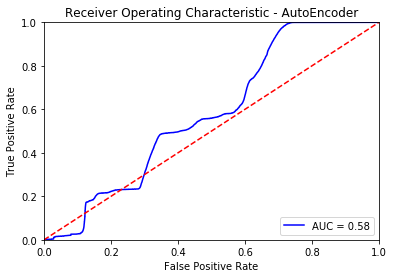

W1101 23:07:27.866107 12740 deprecation.py:323] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1101 23:07:27.894092 12740 deprecation.py:323] From C:\Users\andre\Anaconda3\envs\security\lib\site-packages\tensorflow\python\ops\variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Accuracy:  0.7314
Precision:  0.21274509803921568
Recall:  0.21158346333853353
F1-score:  0.2121626906531091
Duration:  100.328818  seconds


Epoch 1 of 60

Testing for epoch 1 index 1:


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Testing for epoch 1 index 33:

Testing for epo

Testing for epoch 3 index 32:

Testing for epoch 3 index 33:

Testing for epoch 3 index 34:

Testing for epoch 3 index 35:

Testing for epoch 3 index 36:

Testing for epoch 3 index 37:

Testing for epoch 3 index 38:

Testing for epoch 3 index 39:

Testing for epoch 3 index 40:

Testing for epoch 3 index 41:

Testing for epoch 3 index 42:

Testing for epoch 3 index 43:

Testing for epoch 3 index 44:

Testing for epoch 3 index 45:

Testing for epoch 3 index 46:

Testing for epoch 3 index 47:

Testing for epoch 3 index 48:

Testing for epoch 3 index 49:

Testing for epoch 3 index 50:

Testing for epoch 3 index 51:

Testing for epoch 3 index 52:

Testing for epoch 3 index 53:

Testing for epoch 3 index 54:

Testing for epoch 3 index 55:

Testing for epoch 3 index 56:

Testing for epoch 3 index 57:

Testing for epoch 3 index 58:

Testing for epoch 3 index 59:

Testing for epoch 3 index 60:

Testing for epoch 3 index 61:

Testing for epoch 3 index 62:

Testing for epoch 3 index 63:

Testing 

Testing for epoch 5 index 58:

Testing for epoch 5 index 59:

Testing for epoch 5 index 60:

Testing for epoch 5 index 61:

Testing for epoch 5 index 62:

Testing for epoch 5 index 63:

Testing for epoch 5 index 64:

Testing for epoch 5 index 65:

Testing for epoch 5 index 66:

Testing for epoch 5 index 67:

Testing for epoch 5 index 68:

Testing for epoch 5 index 69:

Testing for epoch 5 index 70:

Testing for epoch 5 index 71:

Testing for epoch 5 index 72:

Testing for epoch 5 index 73:

Testing for epoch 5 index 74:

Testing for epoch 5 index 75:

Testing for epoch 5 index 76:

Testing for epoch 5 index 77:

Testing for epoch 5 index 78:

Testing for epoch 5 index 79:

Testing for epoch 5 index 80:

Testing for epoch 5 index 81:

Testing for epoch 5 index 82:

Testing for epoch 5 index 83:

Testing for epoch 5 index 84:

Testing for epoch 5 index 85:

Testing for epoch 5 index 86:

Testing for epoch 5 index 87:

Testing for epoch 5 index 88:

Testing for epoch 5 index 89:

Testing 

Testing for epoch 7 index 85:

Testing for epoch 7 index 86:

Testing for epoch 7 index 87:

Testing for epoch 7 index 88:

Testing for epoch 7 index 89:

Testing for epoch 7 index 90:

Testing for epoch 7 index 91:

Testing for epoch 7 index 92:

Testing for epoch 7 index 93:

Testing for epoch 7 index 94:

Testing for epoch 7 index 95:

Testing for epoch 7 index 96:

Testing for epoch 7 index 97:

Testing for epoch 7 index 98:

Testing for epoch 7 index 99:

Testing for epoch 7 index 100:

Testing for epoch 7 index 101:

Testing for epoch 7 index 102:

Testing for epoch 7 index 103:

Testing for epoch 7 index 104:

Testing for epoch 7 index 105:

Testing for epoch 7 index 106:

Testing for epoch 7 index 107:

Testing for epoch 7 index 108:

Testing for epoch 7 index 109:

Testing for epoch 7 index 110:

Testing for epoch 7 index 111:

Testing for epoch 7 index 112:

Testing for epoch 7 index 113:

Testing for epoch 7 index 114:

Testing for epoch 7 index 115:

Testing for epoch 7 ind

Testing for epoch 9 index 116:

Testing for epoch 9 index 117:

Testing for epoch 9 index 118:

Testing for epoch 9 index 119:

Testing for epoch 9 index 120:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:

Testing for epoch 10 index 3:

Testing for epoch 10 index 4:

Testing for epoch 10 index 5:

Testing for epoch 10 index 6:

Testing for epoch 10 index 7:

Testing for epoch 10 index 8:

Testing for epoch 10 index 9:

Testing for epoch 10 index 10:

Testing for epoch 10 index 11:

Testing for epoch 10 index 12:

Testing for epoch 10 index 13:

Testing for epoch 10 index 14:

Testing for epoch 10 index 15:

Testing for epoch 10 index 16:

Testing for epoch 10 index 17:

Testing for epoch 10 index 18:

Testing for epoch 10 index 19:

Testing for epoch 10 index 20:

Testing for epoch 10 index 21:

Testing for epoch 10 index 22:

Testing for epoch 10 index 23:

Testing for epoch 10 index 24:

Testing for epoch 10 index 25:

Testing for epoch 10 index 26:

Te

Testing for epoch 12 index 11:

Testing for epoch 12 index 12:

Testing for epoch 12 index 13:

Testing for epoch 12 index 14:

Testing for epoch 12 index 15:

Testing for epoch 12 index 16:

Testing for epoch 12 index 17:

Testing for epoch 12 index 18:

Testing for epoch 12 index 19:

Testing for epoch 12 index 20:

Testing for epoch 12 index 21:

Testing for epoch 12 index 22:

Testing for epoch 12 index 23:

Testing for epoch 12 index 24:

Testing for epoch 12 index 25:

Testing for epoch 12 index 26:

Testing for epoch 12 index 27:

Testing for epoch 12 index 28:

Testing for epoch 12 index 29:

Testing for epoch 12 index 30:

Testing for epoch 12 index 31:

Testing for epoch 12 index 32:

Testing for epoch 12 index 33:

Testing for epoch 12 index 34:

Testing for epoch 12 index 35:

Testing for epoch 12 index 36:

Testing for epoch 12 index 37:

Testing for epoch 12 index 38:

Testing for epoch 12 index 39:

Testing for epoch 12 index 40:

Testing for epoch 12 index 41:

Testing 

Testing for epoch 14 index 30:

Testing for epoch 14 index 31:

Testing for epoch 14 index 32:

Testing for epoch 14 index 33:

Testing for epoch 14 index 34:

Testing for epoch 14 index 35:

Testing for epoch 14 index 36:

Testing for epoch 14 index 37:

Testing for epoch 14 index 38:

Testing for epoch 14 index 39:

Testing for epoch 14 index 40:

Testing for epoch 14 index 41:

Testing for epoch 14 index 42:

Testing for epoch 14 index 43:

Testing for epoch 14 index 44:

Testing for epoch 14 index 45:

Testing for epoch 14 index 46:

Testing for epoch 14 index 47:

Testing for epoch 14 index 48:

Testing for epoch 14 index 49:

Testing for epoch 14 index 50:

Testing for epoch 14 index 51:

Testing for epoch 14 index 52:

Testing for epoch 14 index 53:

Testing for epoch 14 index 54:

Testing for epoch 14 index 55:

Testing for epoch 14 index 56:

Testing for epoch 14 index 57:

Testing for epoch 14 index 58:

Testing for epoch 14 index 59:

Testing for epoch 14 index 60:

Testing 

Testing for epoch 16 index 49:

Testing for epoch 16 index 50:

Testing for epoch 16 index 51:

Testing for epoch 16 index 52:

Testing for epoch 16 index 53:

Testing for epoch 16 index 54:

Testing for epoch 16 index 55:

Testing for epoch 16 index 56:

Testing for epoch 16 index 57:

Testing for epoch 16 index 58:

Testing for epoch 16 index 59:

Testing for epoch 16 index 60:

Testing for epoch 16 index 61:

Testing for epoch 16 index 62:

Testing for epoch 16 index 63:

Testing for epoch 16 index 64:

Testing for epoch 16 index 65:

Testing for epoch 16 index 66:

Testing for epoch 16 index 67:

Testing for epoch 16 index 68:

Testing for epoch 16 index 69:

Testing for epoch 16 index 70:

Testing for epoch 16 index 71:

Testing for epoch 16 index 72:

Testing for epoch 16 index 73:

Testing for epoch 16 index 74:

Testing for epoch 16 index 75:

Testing for epoch 16 index 76:

Testing for epoch 16 index 77:

Testing for epoch 16 index 78:

Testing for epoch 16 index 79:

Testing 

Testing for epoch 18 index 70:

Testing for epoch 18 index 71:

Testing for epoch 18 index 72:

Testing for epoch 18 index 73:

Testing for epoch 18 index 74:

Testing for epoch 18 index 75:

Testing for epoch 18 index 76:

Testing for epoch 18 index 77:

Testing for epoch 18 index 78:

Testing for epoch 18 index 79:

Testing for epoch 18 index 80:

Testing for epoch 18 index 81:

Testing for epoch 18 index 82:

Testing for epoch 18 index 83:

Testing for epoch 18 index 84:

Testing for epoch 18 index 85:

Testing for epoch 18 index 86:

Testing for epoch 18 index 87:

Testing for epoch 18 index 88:

Testing for epoch 18 index 89:

Testing for epoch 18 index 90:

Testing for epoch 18 index 91:

Testing for epoch 18 index 92:

Testing for epoch 18 index 93:

Testing for epoch 18 index 94:

Testing for epoch 18 index 95:

Testing for epoch 18 index 96:

Testing for epoch 18 index 97:

Testing for epoch 18 index 98:

Testing for epoch 18 index 99:

Testing for epoch 18 index 100:

Testing

Testing for epoch 20 index 92:

Testing for epoch 20 index 93:

Testing for epoch 20 index 94:

Testing for epoch 20 index 95:

Testing for epoch 20 index 96:

Testing for epoch 20 index 97:

Testing for epoch 20 index 98:

Testing for epoch 20 index 99:

Testing for epoch 20 index 100:

Testing for epoch 20 index 101:

Testing for epoch 20 index 102:

Testing for epoch 20 index 103:

Testing for epoch 20 index 104:

Testing for epoch 20 index 105:

Testing for epoch 20 index 106:

Testing for epoch 20 index 107:

Testing for epoch 20 index 108:

Testing for epoch 20 index 109:

Testing for epoch 20 index 110:

Testing for epoch 20 index 111:

Testing for epoch 20 index 112:

Testing for epoch 20 index 113:

Testing for epoch 20 index 114:

Testing for epoch 20 index 115:

Testing for epoch 20 index 116:

Testing for epoch 20 index 117:

Testing for epoch 20 index 118:

Testing for epoch 20 index 119:

Testing for epoch 20 index 120:
Epoch 21 of 60

Testing for epoch 21 index 1:

Testi

500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 40:
500/500 [==============================] - 0s 30us/step

Testing for epoch 22 index 41:
500/500 [==============================] - 0s 28us/step

Testing for epoch 22 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 43:
500/500 [==============================] - 0s 30us/step

Testing for epoch 22 index 44:
500/500 [==============================] - 0s 30us/step

Testing for epoch 22 index 45:
500/500 [==============================] - 0s 28us/step

Testing for epoch 22 index 46:
500/500 [==============================] - 0s 26us/step

Testing for epoch 22 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 48:
500/500 [==============================] - 0s 28us/step

Testing for epoch 22 index 49:
500/500 [==============================] - 0s 28us/step

Testing for epoch 22 index 50:
500/500 [=======================


Testing for epoch 23 index 12:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 13:
500/500 [==============================] - 0s 26us/step

Testing for epoch 23 index 14:
500/500 [==============================] - 0s 24us/step

Testing for epoch 23 index 15:
500/500 [==============================] - 0s 26us/step

Testing for epoch 23 index 16:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 17:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 18:
500/500 [==============================] - 0s 30us/step

Testing for epoch 23 index 19:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 20:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 21:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 22:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 23:


500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 106:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 107:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 108:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 109:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 110:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 111:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 112:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 113:
500/500 [==============================] - 0s 30us/step

Testing for epoch 23 index 114:
500/500 [==============================] - 0s 30us/step

Testing for epoch 23 index 115:
500/500 [==============================] - 0s 28us/step

Testing for epoch 23 index 116:
500/500 [============

500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 79:
500/500 [==============================] - 0s 26us/step

Testing for epoch 24 index 80:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 81:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 82:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 83:
500/500 [==============================] - 0s 26us/step

Testing for epoch 24 index 84:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 85:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 86:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 87:
500/500 [==============================] - 0s 28us/step

Testing for epoch 24 index 88:
500/500 [==============================] - 0s 30us/step

Testing for epoch 24 index 89:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 52:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 53:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 54:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 56:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 57:
500/500 [==============================] - 0s 42us/step

Testing for epoch 25 index 58:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 59:
500/500 [==============================] - 0s 40us/step

Testing for epoch 25 index 60:
500/500 [==============================] - 0s 40us/step

Testing for epoch 25 index 61:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 62:
500/500 [=======================

500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 25:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 26:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 27:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 28:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 29:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 30:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 31:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 32:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 33:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 34:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 35:
500/500 [=======================

500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 118:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 119:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 120:
500/500 [==============================] - 0s 26us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 2:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 4:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 5:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 6:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 7:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 8:
500/500 [=============

500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 91:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 92:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 93:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 94:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 95:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 96:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 97:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 98:
500/500 [==============================] - ETA:  - 0s 28us/step

Testing for epoch 27 index 99:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 100:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 101:
500/500 [=============

500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 64:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 65:
500/500 [==============================] - 0s 26us/step

Testing for epoch 28 index 66:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 67:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 68:
500/500 [==============================] - 0s 26us/step

Testing for epoch 28 index 69:
500/500 [==============================] - 0s 26us/step

Testing for epoch 28 index 70:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 71:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 72:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 73:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 74:
500/500 [=======================

500/500 [==============================] - 0s 28us/step

Testing for epoch 29 index 37:
500/500 [==============================] - 0s 28us/step

Testing for epoch 29 index 38:
500/500 [==============================] - 0s 26us/step

Testing for epoch 29 index 39:
500/500 [==============================] - 0s 28us/step

Testing for epoch 29 index 40:
500/500 [==============================] - 0s 38us/step

Testing for epoch 29 index 41:
500/500 [==============================] - 0s 38us/step

Testing for epoch 29 index 42:
500/500 [==============================] - 0s 40us/step

Testing for epoch 29 index 43:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 44:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 45:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 46:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 47:
500/500 [=======================

500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 10:
500/500 [==============================] - 0s 52us/step

Testing for epoch 30 index 11:
500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 12:
500/500 [==============================] - 0s 50us/step

Testing for epoch 30 index 13:
500/500 [==============================] - 0s 54us/step

Testing for epoch 30 index 14:
500/500 [==============================] - 0s 58us/step

Testing for epoch 30 index 15:
500/500 [==============================] - 0s 52us/step

Testing for epoch 30 index 16:
500/500 [==============================] - 0s 54us/step

Testing for epoch 30 index 17:
500/500 [==============================] - 0s 46us/step

Testing for epoch 30 index 18:
500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 19:
500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 20:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 103:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 104:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 105:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 106:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 107:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 108:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 109:
500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 110:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 111:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 112:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 113:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 76:
500/500 [==============================] - 0s 30us/step

Testing for epoch 31 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 79:
500/500 [==============================] - 0s 30us/step

Testing for epoch 31 index 80:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 83:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 84:
500/500 [==============================] - 0s 35us/step

Testing for epoch 31 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 86:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 50:
500/500 [==============================] - 0s 40us/step

Testing for epoch 32 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 55:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 56:
500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 57:
500/500 [==============================] - 0s 40us/step

Testing for epoch 32 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 59:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 23:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 24:
500/500 [==============================] - 0s 56us/step

Testing for epoch 33 index 25:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 26:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 30:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 31:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 32:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 33 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 116:
500/500 [==============================] - 0s 30us/step

Testing for epoch 33 index 117:
500/500 [==============================] - 0s 30us/step

Testing for epoch 33 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 2:
500/500 [==============================] - ETA:  - 0s 34us/step

Testing for epoch 34 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 34 index 4:
500/500 [==============================] - 0s 30us/step

Testing for epoch 34 index 5:
500/500 

500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 89:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 92:
500/500 [==============================] - 0s 30us/step

Testing for epoch 34 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 95:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 34 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 98:
500/500 [===============

500/500 [==============================] - 0s 48us/step

Testing for epoch 35 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 63:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 64:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 68:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 69:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 70:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 33:
500/500 [==============================] - 0s 44us/step

Testing for epoch 36 index 34:
500/500 [==============================] - 0s 46us/step

Testing for epoch 36 index 35:
500/500 [==============================] - 0s 44us/step

Testing for epoch 36 index 36:
500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 37:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 38:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 39:
500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 40:
500/500 [==============================] - 0s 48us/step

Testing for epoch 36 index 41:
500/500 [==============================] - 0s 44us/step

Testing for epoch 36 index 42:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 43:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 6:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 37 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 12:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 14:
500/500 [==============================] - 0s 38us/step

Testing for epoch 37 index 15:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 16:
500/500 [===========================

500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 100:
500/500 [==============================] - 0s 30us/step

Testing for epoch 37 index 101:
500/500 [==============================] - 0s 38us/step

Testing for epoch 37 index 102:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 104:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 105:
500/500 [==============================] - 0s 30us/step

Testing for epoch 37 index 106:
500/500 [==============================] - 0s 38us/step

Testing for epoch 37 index 107:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 109:
500/500 [=============


Testing for epoch 38 index 71:
500/500 [==============================] - 0s 30us/step

Testing for epoch 38 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 73:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 74:
500/500 [==============================] - 0s 28us/step

Testing for epoch 38 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 76:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 82:


500/500 [==============================] - 0s 30us/step

Testing for epoch 39 index 44:
500/500 [==============================] - ETA:  - 0s 34us/step

Testing for epoch 39 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 50:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 52:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 53:
500/500 [==============================] - 0s 40us/step

Testing for epoch 39 index 54:
500/500 [===============

Testing for epoch 40 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 17:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 19:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 22:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 24:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 25:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 26:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 27:
5

500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 111:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 114:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 115:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 117:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 118:
500/500 [==============================] - 0s 42us/step

Testing for epoch 40 index 119:
500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 120:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 83:
500/500 [==============================] - 0s 38us/step

Testing for epoch 41 index 84:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 88:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 89:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 91:
500/500 [==============================] - 0s 38us/step

Testing for epoch 41 index 92:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 93:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 57:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 58:
500/500 [==============================] - 0s 38us/step

Testing for epoch 42 index 59:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 61:
500/500 [==============================] - 0s 44us/step

Testing for epoch 42 index 62:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 63:
500/500 [==============================] - 0s 40us/step

Testing for epoch 42 index 64:
500/500 [==============================] - 0s 38us/step

Testing for epoch 42 index 65:
500/500 [==============================] - 0s 38us/step

Testing for epoch 42 index 66:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 43 index 29:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 30:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 31:
500/500 [==============================] - 0s 46us/step

Testing for epoch 43 index 32:
500/500 [==============================] - 0s 44us/step

Testing for epoch 43 index 33:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 34:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 35:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 36:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 37:
500/500 [==============================] - 0s 40us/step

Testing for epoch 43 index 38:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 39:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 44us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 38us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 10:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 95:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 96:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 102:
500/500 [==============================] - 0s 33us/step

Testing for epoch 44 index 103:
500/500 [==============================] - 0s 38us/step

Testing for epoch 44 index 104:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 105:
500/500 [=================

500/500 [==============================] - 0s 50us/step

Testing for epoch 45 index 68:
500/500 [==============================] - 0s 50us/step

Testing for epoch 45 index 69:
500/500 [==============================] - 0s 52us/step

Testing for epoch 45 index 70:
500/500 [==============================] - 0s 56us/step

Testing for epoch 45 index 71:
500/500 [==============================] - 0s 50us/step

Testing for epoch 45 index 72:
500/500 [==============================] - 0s 52us/step

Testing for epoch 45 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 74:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 75:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 77:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 78:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 44:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 51:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 15:
500/500 [==============================] - 0s 28us/step

Testing for epoch 47 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 17:
500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 23:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 24:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 107:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 109:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 110:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 112:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 117:
500/500 [============

500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 80:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 81:
500/500 [==============================] - 0s 28us/step

Testing for epoch 48 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 85:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 89:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 90:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 52:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 53:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 54:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 55:
500/500 [==============================] - 0s 28us/step

Testing for epoch 49 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 57:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 58:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 59:
500/500 [==============================] - 0s 28us/step

Testing for epoch 49 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 61:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 62:
500/500 [=======================

500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 25:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 26:
500/500 [==============================] - ETA:  - 0s 56us/step

Testing for epoch 50 index 27:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 28:
500/500 [==============================] - 0s 50us/step

Testing for epoch 50 index 29:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 30:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 31:
500/500 [==============================] - 0s 48us/step

Testing for epoch 50 index 32:
500/500 [==============================] - 0s 56us/step

Testing for epoch 50 index 33:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 34:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 35:
500/500 [===============

500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 119:
500/500 [==============================] - 0s 54us/step

Testing for epoch 50 index 120:
500/500 [==============================] - 0s 58us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [==============================] - 0s 60us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 3:
500/500 [==============================] - 0s 64us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 51 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 51 index 8:
500/500 [=============

500/500 [==============================] - 0s 125us/step

Testing for epoch 51 index 91:
500/500 [==============================] - 0s 104us/step

Testing for epoch 51 index 92:
500/500 [==============================] - 0s 74us/step

Testing for epoch 51 index 93:
500/500 [==============================] - 0s 82us/step

Testing for epoch 51 index 94:
500/500 [==============================] - 0s 70us/step

Testing for epoch 51 index 95:
500/500 [==============================] - 0s 74us/step

Testing for epoch 51 index 96:
500/500 [==============================] - 0s 66us/step

Testing for epoch 51 index 97:
500/500 [==============================] - 0s 58us/step

Testing for epoch 51 index 98:
500/500 [==============================] - 0s 68us/step

Testing for epoch 51 index 99:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 100:
500/500 [==============================] - 0s 62us/step

Testing for epoch 51 index 101:
500/500 [===================

500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 67:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 69:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 70:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 71:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 72:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 73:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 74:
500/500 [=======================


Testing for epoch 53 index 36:
500/500 [==============================] - 0s 30us/step

Testing for epoch 53 index 37:
500/500 [==============================] - 0s 38us/step

Testing for epoch 53 index 38:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 39:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 40:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 42:
500/500 [==============================] - 0s 38us/step

Testing for epoch 53 index 43:
500/500 [==============================] - 0s 28us/step

Testing for epoch 53 index 44:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 47:


500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 10:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 54 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 15:
500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 19:
500/500 [========================

500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 102:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 105:
500/500 [==============================] - 0s 30us/step

Testing for epoch 54 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 107:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 108:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 110:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 111:
500/500 [==============================] - ETA:  - 0s 34us/step

Testing for epoch 54 index 112:
500/500 [====

500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 75:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 78:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 84:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 85:
500/500 [=======================

500/500 [==============================] - 0s 54us/step

Testing for epoch 56 index 48:
500/500 [==============================] - 0s 60us/step

Testing for epoch 56 index 49:
500/500 [==============================] - 0s 50us/step

Testing for epoch 56 index 50:
500/500 [==============================] - 0s 56us/step

Testing for epoch 56 index 51:
500/500 [==============================] - 0s 58us/step

Testing for epoch 56 index 52:
500/500 [==============================] - 0s 54us/step

Testing for epoch 56 index 53:
500/500 [==============================] - 0s 52us/step

Testing for epoch 56 index 54:
500/500 [==============================] - 0s 56us/step

Testing for epoch 56 index 55:
500/500 [==============================] - 0s 54us/step

Testing for epoch 56 index 56:
500/500 [==============================] - 0s 52us/step

Testing for epoch 56 index 57:
500/500 [==============================] - 0s 56us/step

Testing for epoch 56 index 58:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 21:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 22:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 24:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 27:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 28:
500/500 [==============================] - 0s 30us/step

Testing for epoch 57 index 29:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 31:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 114:
500/500 [==============================] - 0s 30us/step

Testing for epoch 57 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 116:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 117:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 119:
500/500 [==============================] - 0s 30us/step

Testing for epoch 57 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 4:
500/500 [=====

500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 87:
500/500 [==============================] - 0s 30us/step

Testing for epoch 58 index 88:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 89:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 92:
500/500 [==============================] - 0s 46us/step

Testing for epoch 58 index 93:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 94:
500/500 [==============================] - 0s 46us/step

Testing for epoch 58 index 95:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 97:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 61:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 59 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 59 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 70:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 60 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 34:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 60 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 36:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 38:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 40:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 41:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 42:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 43:
500/500 [===============

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


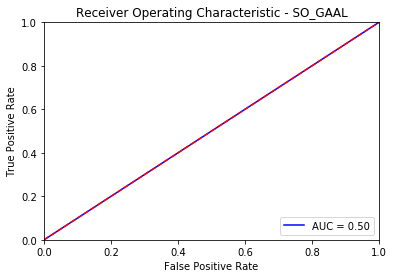

Accuracy:  0.8290666666666666
Precision: -
Recall:  0.0
F1-score: -
Duration:  236.507869  seconds


Epoch 1 of 60

Testing for epoch 1 index 1:


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Testing for epoch 1 index 33:

Testing for epo


Testing for epoch 3 index 25:

Testing for epoch 3 index 26:

Testing for epoch 3 index 27:

Testing for epoch 3 index 28:

Testing for epoch 3 index 29:

Testing for epoch 3 index 30:

Testing for epoch 3 index 31:

Testing for epoch 3 index 32:

Testing for epoch 3 index 33:

Testing for epoch 3 index 34:

Testing for epoch 3 index 35:

Testing for epoch 3 index 36:

Testing for epoch 3 index 37:

Testing for epoch 3 index 38:

Testing for epoch 3 index 39:

Testing for epoch 3 index 40:

Testing for epoch 3 index 41:

Testing for epoch 3 index 42:

Testing for epoch 3 index 43:

Testing for epoch 3 index 44:

Testing for epoch 3 index 45:

Testing for epoch 3 index 46:

Testing for epoch 3 index 47:

Testing for epoch 3 index 48:

Testing for epoch 3 index 49:

Testing for epoch 3 index 50:

Testing for epoch 3 index 51:

Testing for epoch 3 index 52:

Testing for epoch 3 index 53:

Testing for epoch 3 index 54:

Testing for epoch 3 index 55:

Testing for epoch 3 index 56:

Testing


Testing for epoch 5 index 48:

Testing for epoch 5 index 49:

Testing for epoch 5 index 50:

Testing for epoch 5 index 51:

Testing for epoch 5 index 52:

Testing for epoch 5 index 53:

Testing for epoch 5 index 54:

Testing for epoch 5 index 55:

Testing for epoch 5 index 56:

Testing for epoch 5 index 57:

Testing for epoch 5 index 58:

Testing for epoch 5 index 59:

Testing for epoch 5 index 60:

Testing for epoch 5 index 61:

Testing for epoch 5 index 62:

Testing for epoch 5 index 63:

Testing for epoch 5 index 64:

Testing for epoch 5 index 65:

Testing for epoch 5 index 66:

Testing for epoch 5 index 67:

Testing for epoch 5 index 68:

Testing for epoch 5 index 69:

Testing for epoch 5 index 70:

Testing for epoch 5 index 71:

Testing for epoch 5 index 72:

Testing for epoch 5 index 73:

Testing for epoch 5 index 74:

Testing for epoch 5 index 75:

Testing for epoch 5 index 76:

Testing for epoch 5 index 77:

Testing for epoch 5 index 78:

Testing for epoch 5 index 79:

Testing


Testing for epoch 7 index 71:

Testing for epoch 7 index 72:

Testing for epoch 7 index 73:

Testing for epoch 7 index 74:

Testing for epoch 7 index 75:

Testing for epoch 7 index 76:

Testing for epoch 7 index 77:

Testing for epoch 7 index 78:

Testing for epoch 7 index 79:

Testing for epoch 7 index 80:

Testing for epoch 7 index 81:

Testing for epoch 7 index 82:

Testing for epoch 7 index 83:

Testing for epoch 7 index 84:

Testing for epoch 7 index 85:

Testing for epoch 7 index 86:

Testing for epoch 7 index 87:

Testing for epoch 7 index 88:

Testing for epoch 7 index 89:

Testing for epoch 7 index 90:

Testing for epoch 7 index 91:

Testing for epoch 7 index 92:

Testing for epoch 7 index 93:

Testing for epoch 7 index 94:

Testing for epoch 7 index 95:

Testing for epoch 7 index 96:

Testing for epoch 7 index 97:

Testing for epoch 7 index 98:

Testing for epoch 7 index 99:

Testing for epoch 7 index 100:

Testing for epoch 7 index 101:

Testing for epoch 7 index 102:

Test


Testing for epoch 9 index 94:

Testing for epoch 9 index 95:

Testing for epoch 9 index 96:

Testing for epoch 9 index 97:

Testing for epoch 9 index 98:

Testing for epoch 9 index 99:

Testing for epoch 9 index 100:

Testing for epoch 9 index 101:

Testing for epoch 9 index 102:

Testing for epoch 9 index 103:

Testing for epoch 9 index 104:

Testing for epoch 9 index 105:

Testing for epoch 9 index 106:

Testing for epoch 9 index 107:

Testing for epoch 9 index 108:

Testing for epoch 9 index 109:

Testing for epoch 9 index 110:

Testing for epoch 9 index 111:

Testing for epoch 9 index 112:

Testing for epoch 9 index 113:

Testing for epoch 9 index 114:

Testing for epoch 9 index 115:

Testing for epoch 9 index 116:

Testing for epoch 9 index 117:

Testing for epoch 9 index 118:

Testing for epoch 9 index 119:

Testing for epoch 9 index 120:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:

Testing for epoch 10 index 3:

Testing for epoch 10 index 4:

Te


Testing for epoch 11 index 109:

Testing for epoch 11 index 110:

Testing for epoch 11 index 111:

Testing for epoch 11 index 112:

Testing for epoch 11 index 113:

Testing for epoch 11 index 114:

Testing for epoch 11 index 115:

Testing for epoch 11 index 116:

Testing for epoch 11 index 117:

Testing for epoch 11 index 118:

Testing for epoch 11 index 119:

Testing for epoch 11 index 120:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:

Testing for epoch 12 index 3:

Testing for epoch 12 index 4:

Testing for epoch 12 index 5:

Testing for epoch 12 index 6:

Testing for epoch 12 index 7:

Testing for epoch 12 index 8:

Testing for epoch 12 index 9:

Testing for epoch 12 index 10:

Testing for epoch 12 index 11:

Testing for epoch 12 index 12:

Testing for epoch 12 index 13:

Testing for epoch 12 index 14:

Testing for epoch 12 index 15:

Testing for epoch 12 index 16:

Testing for epoch 12 index 17:

Testing for epoch 12 index 18:

Testing for epoch 12 


Testing for epoch 14 index 3:

Testing for epoch 14 index 4:

Testing for epoch 14 index 5:

Testing for epoch 14 index 6:

Testing for epoch 14 index 7:

Testing for epoch 14 index 8:

Testing for epoch 14 index 9:

Testing for epoch 14 index 10:

Testing for epoch 14 index 11:

Testing for epoch 14 index 12:

Testing for epoch 14 index 13:

Testing for epoch 14 index 14:

Testing for epoch 14 index 15:

Testing for epoch 14 index 16:

Testing for epoch 14 index 17:

Testing for epoch 14 index 18:

Testing for epoch 14 index 19:

Testing for epoch 14 index 20:

Testing for epoch 14 index 21:

Testing for epoch 14 index 22:

Testing for epoch 14 index 23:

Testing for epoch 14 index 24:

Testing for epoch 14 index 25:

Testing for epoch 14 index 26:

Testing for epoch 14 index 27:

Testing for epoch 14 index 28:

Testing for epoch 14 index 29:

Testing for epoch 14 index 30:

Testing for epoch 14 index 31:

Testing for epoch 14 index 32:

Testing for epoch 14 index 33:

Testing for ep


Testing for epoch 16 index 18:

Testing for epoch 16 index 19:

Testing for epoch 16 index 20:

Testing for epoch 16 index 21:

Testing for epoch 16 index 22:

Testing for epoch 16 index 23:

Testing for epoch 16 index 24:

Testing for epoch 16 index 25:

Testing for epoch 16 index 26:

Testing for epoch 16 index 27:

Testing for epoch 16 index 28:

Testing for epoch 16 index 29:

Testing for epoch 16 index 30:

Testing for epoch 16 index 31:

Testing for epoch 16 index 32:

Testing for epoch 16 index 33:

Testing for epoch 16 index 34:

Testing for epoch 16 index 35:

Testing for epoch 16 index 36:

Testing for epoch 16 index 37:

Testing for epoch 16 index 38:

Testing for epoch 16 index 39:

Testing for epoch 16 index 40:

Testing for epoch 16 index 41:

Testing for epoch 16 index 42:

Testing for epoch 16 index 43:

Testing for epoch 16 index 44:

Testing for epoch 16 index 45:

Testing for epoch 16 index 46:

Testing for epoch 16 index 47:

Testing for epoch 16 index 48:

Testing


Testing for epoch 18 index 33:

Testing for epoch 18 index 34:

Testing for epoch 18 index 35:

Testing for epoch 18 index 36:

Testing for epoch 18 index 37:

Testing for epoch 18 index 38:

Testing for epoch 18 index 39:

Testing for epoch 18 index 40:

Testing for epoch 18 index 41:

Testing for epoch 18 index 42:

Testing for epoch 18 index 43:

Testing for epoch 18 index 44:

Testing for epoch 18 index 45:

Testing for epoch 18 index 46:

Testing for epoch 18 index 47:

Testing for epoch 18 index 48:

Testing for epoch 18 index 49:

Testing for epoch 18 index 50:

Testing for epoch 18 index 51:

Testing for epoch 18 index 52:

Testing for epoch 18 index 53:

Testing for epoch 18 index 54:

Testing for epoch 18 index 55:

Testing for epoch 18 index 56:

Testing for epoch 18 index 57:

Testing for epoch 18 index 58:

Testing for epoch 18 index 59:

Testing for epoch 18 index 60:

Testing for epoch 18 index 61:

Testing for epoch 18 index 62:

Testing for epoch 18 index 63:

Testing


Testing for epoch 20 index 48:

Testing for epoch 20 index 49:

Testing for epoch 20 index 50:

Testing for epoch 20 index 51:

Testing for epoch 20 index 52:

Testing for epoch 20 index 53:

Testing for epoch 20 index 54:

Testing for epoch 20 index 55:

Testing for epoch 20 index 56:

Testing for epoch 20 index 57:

Testing for epoch 20 index 58:

Testing for epoch 20 index 59:

Testing for epoch 20 index 60:

Testing for epoch 20 index 61:

Testing for epoch 20 index 62:

Testing for epoch 20 index 63:

Testing for epoch 20 index 64:

Testing for epoch 20 index 65:

Testing for epoch 20 index 66:

Testing for epoch 20 index 67:

Testing for epoch 20 index 68:

Testing for epoch 20 index 69:

Testing for epoch 20 index 70:

Testing for epoch 20 index 71:

Testing for epoch 20 index 72:

Testing for epoch 20 index 73:

Testing for epoch 20 index 74:

Testing for epoch 20 index 75:

Testing for epoch 20 index 76:

Testing for epoch 20 index 77:

Testing for epoch 20 index 78:

Testing

500/500 [==============================] - 0s 37us/step

Testing for epoch 21 index 12:
500/500 [==============================] - 0s 46us/step

Testing for epoch 21 index 13:
500/500 [==============================] - 0s 35us/step

Testing for epoch 21 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 15:
500/500 [==============================] - 0s 35us/step

Testing for epoch 21 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 17:
500/500 [==============================] - 0s 42us/step

Testing for epoch 21 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 19:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 21:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 22:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 27:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 31:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 32:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 35:
500/500 [==============================] - 0s 35us/step

Testing for epoch 21 index 36:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 40:
500/500 [==============================] - 0s 42us/step

Testing for epoch 21 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 44:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 49:
500/500 [==============================] - 0s 46us/step

Testing for epoch 21 index 50:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 21 index 54:
500/500 [==============================] - 0s 50us/step

Testing for epoch 21 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 56:
500/500 [==============================] - 0s 40us/step

Testing for epoch 21 index 57:
500/500 [==============================] - 0s 44us/step

Testing for epoch 21 index 58:
500/500 [==============================] - 0s 50us/step

Testing for epoch 21 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 60:
500/500 [==============================] - 0s 42us/step

Testing for epoch 21 index 61:
500/500 [==============================] - 0s 42us/step

Testing for epoch 21 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 64:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 68:
500/500 [==============================] - 0s 33us/step

Testing for epoch 21 index 69:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 73:
500/500 [==============================] - 0s 44us/step

Testing for epoch 21 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 77:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 81:
500/500 [==============================] - 0s 44us/step

Testing for epoch 21 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 83:
500/500 [==============================] - 0s 46us/step

Testing for epoch 21 index 84:
500/500 [==============================] - 0s 44us/step

Testing for epoch 21 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 86:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 89:
500/500 [==============================] - 0s 44us/step

Testing for epoch 21 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 91:
500/500 [=======================

500/500 [==============================] - 0s 54us/step

Testing for epoch 21 index 95:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 98:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 99:
500/500 [==============================] - 0s 52us/step

Testing for epoch 21 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 102:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 105:
500/500 [=================

500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 109:
500/500 [==============================] - 0s 56us/step

Testing for epoch 21 index 110:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 112:
500/500 [==============================] - 0s 38us/step

Testing for epoch 21 index 113:
500/500 [==============================] - 0s 36us/step

Testing for epoch 21 index 114:
500/500 [==============================] - 0s 35us/step

Testing for epoch 21 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 21 index 116:
500/500 [==============================] - 0s 48us/step

Testing for epoch 21 index 117:
500/500 [==============================] - 0s 48us/step

Testing for epoch 21 index 118:
500/500 [==============================] - 0s 48us/step

Testing for epoch 21 index 119:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 5:
500/500 [==============================] - 0s 35us/step

Testing for epoch 22 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 9:
500/500 [==============================] - 0s 62us/step

Testing for epoch 22 index 10:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 11:
500/500 [==============================] - 0s 62us/step

Testing for epoch 22 index 12:
500/500 [==============================] - 0s 46us/step

Testing for epoch 22 index 13:
500/500 [==============================

500/500 [==============================] - 0s 46us/step

Testing for epoch 22 index 16:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 17:
500/500 [==============================] - 0s 46us/step

Testing for epoch 22 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 21:
500/500 [==============================] - 0s 52us/step

Testing for epoch 22 index 22:
500/500 [==============================] - 0s 37us/step

Testing for epoch 22 index 23:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 24:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 26:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 22 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 31:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 32:
500/500 [==============================] - ETA:  - 0s 38us/step

Testing for epoch 22 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 34:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 37:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 38:
500/500 [==============================] - 0s 46us/step

Testing for epoch 22 index 39:
500/500 [==============================] - 0s 44us/step

Testing for epoch 22 index 40:
500/500 [===============

500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 44:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 45:
500/500 [==============================] - 0s 42us/step

Testing for epoch 22 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 48:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 49:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 50:
500/500 [==============================] - 0s 46us/step

Testing for epoch 22 index 51:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 52:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 53:
500/500 [==============================] - 0s 42us/step

Testing for epoch 22 index 54:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 59:
500/500 [==============================] - 0s 44us/step

Testing for epoch 22 index 60:
500/500 [==============================] - 0s 44us/step

Testing for epoch 22 index 61:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 62:
500/500 [==============================] - 0s 50us/step

Testing for epoch 22 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 68:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 74:
500/500 [==============================] - 0s 58us/step

Testing for epoch 22 index 75:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 77:
500/500 [==============================] - 0s 33us/step

Testing for epoch 22 index 78:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 80:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 82:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 86:
500/500 [==============================] - ETA:  - 0s 52us/step

Testing for epoch 22 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 89:
500/500 [==============================] - 0s 54us/step

Testing for epoch 22 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 94:
500/500 [==============================] - 0s 44us/step

Testing for epoch 22 index 95:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 99:
500/500 [==============================] - 0s 38us/step

Testing for epoch 22 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 22 index 101:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 103:
500/500 [==============================] - 0s 35us/step

Testing for epoch 22 index 104:
500/500 [==============================] - 0s 33us/step

Testing for epoch 22 index 105:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 106:
500/500 [==============================] - 0s 42us/step

Testing for epoch 22 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 109:
500/500 [=============

500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 113:
500/500 [==============================] - 0s 42us/step

Testing for epoch 22 index 114:
500/500 [==============================] - 0s 36us/step

Testing for epoch 22 index 115:
500/500 [==============================] - 0s 48us/step

Testing for epoch 22 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 22 index 118:
500/500 [==============================] - 0s 42us/step

Testing for epoch 22 index 119:
500/500 [==============================] - 0s 40us/step

Testing for epoch 22 index 120:
500/500 [==============================] - 0s 38us/step
Epoch 23 of 60

Testing for epoch 23 index 1:
500/500 [==============================] - 0s 42us/step

Testing for epoch 23 index 2:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 3:
500/500 [===

500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 9:
500/500 [==============================] - 0s 48us/step

Testing for epoch 23 index 10:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 11:
500/500 [==============================] - 0s 56us/step

Testing for epoch 23 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 14:
500/500 [==============================] - 0s 37us/step

Testing for epoch 23 index 15:
500/500 [==============================] - 0s 42us/step

Testing for epoch 23 index 16:
500/500 [==============================] - 0s 42us/step

Testing for epoch 23 index 17:
500/500 [==========================

500/500 [==============================] - 0s 48us/step

Testing for epoch 23 index 21:
500/500 [==============================] - 0s 40us/step

Testing for epoch 23 index 22:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 24:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 26:
500/500 [==============================] - 0s 38us/step

Testing for epoch 23 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 29:
500/500 [==============================] - 0s 33us/step

Testing for epoch 23 index 30:
500/500 [==============================] - 0s 40us/step

Testing for epoch 23 index 31:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 34:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 37:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 38:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 23 index 39:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 44:
500/500 [===============

500/500 [==============================] - 0s 40us/step

Testing for epoch 23 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 50:
500/500 [==============================] - 0s 38us/step

Testing for epoch 23 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 58:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 23 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 23 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 70:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 72:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 77:
500/500 [==============================] - 0s 31us/step

Testing for epoch 23 index 78:
500/500 [==============================] - 0s 35us/step

Testing for epoch 23 index 79:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 81:
500/500 [==============================] - 0s 42us/step

Testing for epoch 23 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 83:
500/500 [==============================] - 0s 37us/step

Testing for epoch 23 index 84:
500/500 [==============================] - 0s 46us/step

Testing for epoch 23 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 86:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 23 index 90:
500/500 [==============================] - 0s 33us/step

Testing for epoch 23 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 23 index 95:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 97:
500/500 [==============================] - 0s 38us/step

Testing for epoch 23 index 98:
500/500 [==============================] - 0s 54us/step

Testing for epoch 23 index 99:
500/500 [==============================] - 0s 46us/step

Testing for epoch 23 index 100:
500/500 [======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 105:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 107:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 110:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 113:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 23 index 117:
500/500 [==============================] - 0s 40us/step

Testing for epoch 23 index 118:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 119:
500/500 [==============================] - 0s 44us/step

Testing for epoch 23 index 120:
500/500 [==============================] - 0s 30us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 2:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 4:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 7:
500/500 [===========

500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 11:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 12:
500/500 [==============================] - 0s 46us/step

Testing for epoch 24 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 15:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 19:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 21:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 24 index 25:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 32:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 34:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 35:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 39:
500/500 [==============================] - 0s 42us/step

Testing for epoch 24 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 41:
500/500 [==============================] - 0s 40us/step

Testing for epoch 24 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 43:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 45:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 49:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 52:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 53:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 54:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 57:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 58:
500/500 [==============================] - 0s 43us/step

Testing for epoch 24 index 59:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 61:
500/500 [==============================] - 0s 58us/step

Testing for epoch 24 index 62:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 24 index 66:
500/500 [==============================] - 0s 40us/step

Testing for epoch 24 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 68:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 69:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 70:
500/500 [==============================] - 0s 44us/step

Testing for epoch 24 index 71:
500/500 [==============================] - 0s 33us/step

Testing for epoch 24 index 72:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 73:
500/500 [==============================] - 0s 42us/step

Testing for epoch 24 index 74:
500/500 [==============================] - 0s 40us/step

Testing for epoch 24 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 76:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 81:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 88:
500/500 [==============================] - 0s 42us/step

Testing for epoch 24 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 90:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 94:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 95:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 98:
500/500 [==============================] - 0s 44us/step

Testing for epoch 24 index 99:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 100:
500/500 [==============================] - 0s 38us/step

Testing for epoch 24 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 104:
500/500 [==================

500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 108:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 109:
500/500 [==============================] - 0s 36us/step

Testing for epoch 24 index 110:
500/500 [==============================] - 0s 46us/step

Testing for epoch 24 index 111:
500/500 [==============================] - 0s 40us/step

Testing for epoch 24 index 112:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 24 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 24 index 116:
500/500 [==============================] - 0s 33us/step

Testing for epoch 24 index 117:
500/500 [==============================] - 0s 40us/step

Testing for epoch 24 index 118:
500/500 [============

500/500 [==============================] - 0s 44us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 2:
500/500 [==============================] - 0s 46us/step

Testing for epoch 25 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 8:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 11:
500/500 [=================

500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 16:
500/500 [==============================] - 0s 31us/step

Testing for epoch 25 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 19:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 20:
500/500 [==============================] - 0s 33us/step

Testing for epoch 25 index 21:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 24:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 25:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 31:
500/500 [==============================] - 0s 40us/step

Testing for epoch 25 index 32:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 33:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 35:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 36:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 39:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 45:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 47:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 48:
500/500 [==============================] - 0s 42us/step

Testing for epoch 25 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 50:
500/500 [==============================] - 0s 33us/step

Testing for epoch 25 index 51:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 52:
500/500 [==============================] - 0s 54us/step

Testing for epoch 25 index 53:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 58:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 59:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 61:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 65:
500/500 [==============================] - 0s 56us/step

Testing for epoch 25 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 67:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 72:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 73:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 75:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 76:
500/500 [==============================] - 0s 40us/step

Testing for epoch 25 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 80:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 25 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 86:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 88:
500/500 [==============================] - 0s 48us/step

Testing for epoch 25 index 89:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 91:
500/500 [==============================] - 0s 52us/step

Testing for epoch 25 index 92:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 93:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 94:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 25 index 98:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 99:
500/500 [==============================] - 0s 37us/step

Testing for epoch 25 index 100:
500/500 [==============================] - 0s 52us/step

Testing for epoch 25 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 102:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 104:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 105:
500/500 [==============================] - 0s 37us/step

Testing for epoch 25 index 106:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 107:
500/500 [==============================] - 0s 38us/step

Testing for epoch 25 index 108:
500/500 [==============

500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 112:
500/500 [==============================] - 0s 50us/step

Testing for epoch 25 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 25 index 114:
500/500 [==============================] - 0s 42us/step

Testing for epoch 25 index 115:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 116:
500/500 [==============================] - 0s 33us/step

Testing for epoch 25 index 117:
500/500 [==============================] - 0s 50us/step

Testing for epoch 25 index 118:
500/500 [==============================] - 0s 36us/step

Testing for epoch 25 index 119:
500/500 [==============================] - 0s 33us/step

Testing for epoch 25 index 120:
500/500 [==============================] - 0s 36us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 2:
500/500 [=

500/500 [==============================] - 0s 50us/step

Testing for epoch 26 index 6:
500/500 [==============================] - 0s 40us/step

Testing for epoch 26 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 9:
500/500 [==============================] - 0s 44us/step

Testing for epoch 26 index 10:
500/500 [==============================] - 0s 38us/step

Testing for epoch 26 index 11:
500/500 [==============================] - 0s 35us/step

Testing for epoch 26 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 15:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 16:
500/500 [===========================


Testing for epoch 26 index 19:
500/500 [==============================] - 0s 33us/step

Testing for epoch 26 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 29:
500/500 [==============================] - 0s 44us/step

Testing for epoch 26 index 30:


500/500 [==============================] - 0s 44us/step

Testing for epoch 26 index 33:
500/500 [==============================] - 0s 62us/step

Testing for epoch 26 index 34:
500/500 [==============================] - 0s 50us/step

Testing for epoch 26 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 38:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 39:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 41:
500/500 [==============================] - 0s 42us/step

Testing for epoch 26 index 42:
500/500 [==============================] - 0s 30us/step

Testing for epoch 26 index 43:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 47:
500/500 [==============================] - 0s 42us/step

Testing for epoch 26 index 48:
500/500 [==============================] - 0s 48us/step

Testing for epoch 26 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 51:
500/500 [==============================] - 0s 35us/step

Testing for epoch 26 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 53:
500/500 [==============================] - 0s 56us/step

Testing for epoch 26 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 55:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 57:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 61:
500/500 [==============================] - 0s 35us/step

Testing for epoch 26 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 65:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 71:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 75:
500/500 [==============================] - 0s 38us/step

Testing for epoch 26 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 77:
500/500 [==============================] - 0s 50us/step

Testing for epoch 26 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 83:
500/500 [==============================] - 0s 44us/step

Testing for epoch 26 index 84:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 85:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 89:
500/500 [==============================] - 0s 46us/step

Testing for epoch 26 index 90:
500/500 [==============================] - 0s 58us/step

Testing for epoch 26 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 93:
500/500 [==============================] - 0s 33us/step

Testing for epoch 26 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 95:
500/500 [==============================] - 0s 46us/step

Testing for epoch 26 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 97:
500/500 [==============================] - 0s 33us/step

Testing for epoch 26 index 98:
500/500 [==============================] - 0s 33us/step

Testing for epoch 26 index 99:
500/500 [=======================

500/500 [==============================] - 0s 60us/step

Testing for epoch 26 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 103:
500/500 [==============================] - 0s 37us/step

Testing for epoch 26 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 109:
500/500 [==============================] - 0s 36us/step

Testing for epoch 26 index 110:
500/500 [==============================] - 0s 37us/step

Testing for epoch 26 index 111:
500/500 [==============================] - 0s 42us/step

Testing for epoch 26 index 112:
500/500 [============

500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 26 index 117:
500/500 [==============================] - 0s 38us/step

Testing for epoch 26 index 118:
500/500 [==============================] - 0s 38us/step

Testing for epoch 26 index 119:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 26 index 120:
500/500 [==============================] - 0s 35us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
500/500 [==============================] - 0s 38us/step

Testing for epoch 27 index 2:
500/500 [==============================] - ETA:  - 0s 35us/step

Testing for epoch 27 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 4:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 6:
50

500/500 [==============================] - 0s 38us/step

Testing for epoch 27 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 11:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 27 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 16:
500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 17:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 19:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 20:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 30:
500/500 [==============================] - 0s 48us/step

Testing for epoch 27 index 31:
500/500 [==============================] - 0s 37us/step

Testing for epoch 27 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 33:
500/500 [==============================] - 0s 44us/step

Testing for epoch 27 index 34:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 37:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 38:
500/500 [==============================] - 0s 42us/step

Testing for epoch 27 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 40:
500/500 [==============================] - 0s 54us/step

Testing for epoch 27 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 42:
500/500 [==============================] - 0s 56us/step

Testing for epoch 27 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 47:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 51:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 53:
500/500 [==============================] - 0s 37us/step

Testing for epoch 27 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 55:
500/500 [==============================] - 0s 44us/step

Testing for epoch 27 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 57:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 58:
500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 61:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 27 index 65:
500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 66:
500/500 [==============================] - 0s 38us/step

Testing for epoch 27 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 68:
500/500 [==============================] - 0s 44us/step

Testing for epoch 27 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 70:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 73:
500/500 [==============================] - ETA:  - 0s 38us/step

Testing for epoch 27 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 75:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 79:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 80:
500/500 [==============================] - 0s 46us/step

Testing for epoch 27 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 84:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 85:
500/500 [==============================] - 0s 38us/step

Testing for epoch 27 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 27 index 89:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 93:
500/500 [==============================] - 0s 44us/step

Testing for epoch 27 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 96:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 97:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 99:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 101:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 102:
500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 103:
500/500 [===================

500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 106:
500/500 [==============================] - 0s 64us/step

Testing for epoch 27 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 27 index 111:
500/500 [==============================] - 0s 31us/step

Testing for epoch 27 index 112:
500/500 [==============================] - 0s 37us/step

Testing for epoch 27 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 27 index 115:
500/500 [==============================] - 0s 33us/step

Testing for epoch 27 index 116:
500/500 [============

500/500 [==============================] - 0s 35us/step

Testing for epoch 27 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 5:
500/500 [==============================] - 0s 35us/step

Testing for epoch 28 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 7:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 8:
500/500 [==============================] - 0s 40us/step

Testing for epoch 28 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 10:
500/500 [================

500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 15:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 16:
500/500 [==============================] - 0s 35us/step

Testing for epoch 28 index 17:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 21:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 23:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 24:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 29:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 31:
500/500 [==============================] - 0s 48us/step

Testing for epoch 28 index 32:
500/500 [==============================] - 0s 42us/step

Testing for epoch 28 index 33:
500/500 [==============================] - 0s 40us/step

Testing for epoch 28 index 34:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 35:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 38:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 43:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 47:
500/500 [==============================] - 0s 58us/step

Testing for epoch 28 index 48:
500/500 [==============================] - 0s 35us/step

Testing for epoch 28 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 51:
500/500 [==============================] - 0s 44us/step

Testing for epoch 28 index 52:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 55:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 56:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 58:
500/500 [==============================] - 0s 33us/step

Testing for epoch 28 index 59:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 60:
500/500 [==============================] - 0s 33us/step

Testing for epoch 28 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 65:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 69:
500/500 [==============================] - 0s 33us/step

Testing for epoch 28 index 70:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 71:
500/500 [==============================] - 0s 50us/step

Testing for epoch 28 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 73:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 74:
500/500 [==============================] - 0s 42us/step

Testing for epoch 28 index 75:
500/500 [==============================] - 0s 48us/step

Testing for epoch 28 index 76:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 78:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 79:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 83:
500/500 [==============================] - 0s 46us/step

Testing for epoch 28 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 85:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 86:
500/500 [==============================] - 0s 35us/step

Testing for epoch 28 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 88:
500/500 [==============================] - 0s 38us/step

Testing for epoch 28 index 89:
500/500 [==============================] - 0s 38us/step

Testing for epoch 28 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 91:
500/500 [==============================] - 0s 38us/step

Testing for epoch 28 index 92:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 93:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 97:
500/500 [==============================] - 0s 33us/step

Testing for epoch 28 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 99:
500/500 [==============================] - 0s 36us/step

Testing for epoch 28 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 103:
500/500 [==============================] - 0s 40us/step

Testing for epoch 28 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 106:
500/500 [==============================] - 0s 31us/step

Testing for epoch 28 index 107:
500/500 [===============

500/500 [==============================] - 0s 42us/step

Testing for epoch 28 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 115:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 117:
500/500 [==============================] - 0s 32us/step

Testing for epoch 28 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 28 index 119:
500/500 [==============================] - 0s 35us/step

Testing for epoch 28 index 120:
500/500 [==============================] - 0s 46us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 

500/500 [==============================] - 0s 30us/step

Testing for epoch 29 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 10:
500/500 [==============================] - 0s 44us/step

Testing for epoch 29 index 11:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 12:
500/500 [==============================] - 0s 33us/step

Testing for epoch 29 index 13:
500/500 [==============================] - 0s 48us/step

Testing for epoch 29 index 14:
500/500 [=============================

500/500 [==============================] - 0s 46us/step

Testing for epoch 29 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 19:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 21:
500/500 [==============================] - ETA:  - 0s 34us/step

Testing for epoch 29 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 25:
500/500 [==============================] - 0s 40us/step

Testing for epoch 29 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 27:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 28:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 32:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 34:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 36:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 38:
500/500 [==============================] - 0s 46us/step

Testing for epoch 29 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 42:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 46:
500/500 [==============================] - 0s 33us/step

Testing for epoch 29 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 48:
500/500 [==============================] - 0s 33us/step

Testing for epoch 29 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 50:
500/500 [==============================] - 0s 48us/step

Testing for epoch 29 index 51:
500/500 [==============================] - 0s 40us/step

Testing for epoch 29 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 56:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 60:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 62:
500/500 [==============================] - 0s 56us/step

Testing for epoch 29 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 67:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 68:
500/500 [==============================] - 0s 37us/step

Testing for epoch 29 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 70:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 29 index 73:
500/500 [==============================] - 0s 50us/step

Testing for epoch 29 index 74:
500/500 [==============================] - 0s 52us/step

Testing for epoch 29 index 75:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 76:
500/500 [==============================] - 0s 42us/step

Testing for epoch 29 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 78:
500/500 [==============================] - 0s 37us/step

Testing for epoch 29 index 79:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 80:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 83:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 89:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 91:
500/500 [==============================] - 0s 35us/step

Testing for epoch 29 index 92:
500/500 [==============================] - 0s 37us/step

Testing for epoch 29 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 94:
500/500 [==============================] - 0s 36us/step

Testing for epoch 29 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 97:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 103:
500/500 [==============================] - 0s 33us/step

Testing for epoch 29 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 29 index 106:
500/500 [==============================] - 0s 37us/step

Testing for epoch 29 index 107:
500/500 [==============================] - 0s 35us/step

Testing for epoch 29 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 109:
500/500 [==============================] - 0s 31us/step

Testing for epoch 29 index 110:
500/500 [==============================] - 0s 46us/step

Testing for epoch 29 index 111:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 116:
500/500 [==============================] - 0s 35us/step

Testing for epoch 29 index 117:
500/500 [==============================] - 0s 33us/step

Testing for epoch 29 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 29 index 120:
500/500 [==============================] - 0s 39us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 3:
500/500 [==============================] - 0s 46us/step

Testing for epoch 30 index 4:
500/500 [==============================] - 0s 38us/step

Testing for epoch 30 index 5:
500/500 [=======

500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 10:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 11:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 13:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 14:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 15:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 17:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 18:
500/500 [==============================] - 0s 46us/step

Testing for epoch 30 index 19:
500/500 [========================

500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 22:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 24:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 25:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 27:
500/500 [==============================] - 0s 48us/step

Testing for epoch 30 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 29:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 32:
500/500 [=======================

500/500 [==============================] - 0s 31us/step

Testing for epoch 30 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 37:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 39:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 43:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 44:
500/500 [==============================] - 0s 38us/step

Testing for epoch 30 index 45:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 46:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 51:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 52:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 54:
500/500 [==============================] - 0s 42us/step

Testing for epoch 30 index 55:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 56:
500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 57:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 59:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 60:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 64:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 65:
500/500 [==============================] - 0s 46us/step

Testing for epoch 30 index 66:
500/500 [==============================] - 0s 33us/step

Testing for epoch 30 index 67:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 70:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 71:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 73:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 74:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 78:
500/500 [==============================] - 0s 44us/step

Testing for epoch 30 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 83:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 84:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 86:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 87:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 88:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 91:
500/500 [==============================] - 0s 46us/step

Testing for epoch 30 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 95:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 96:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 97:
500/500 [==============================] - 0s 37us/step

Testing for epoch 30 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 101:
500/500 [=====================

500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 106:
500/500 [==============================] - 0s 36us/step

Testing for epoch 30 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 108:
500/500 [==============================] - 0s 35us/step

Testing for epoch 30 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 112:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 30 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 115:
500/500 [============

500/500 [==============================] - 0s 40us/step

Testing for epoch 30 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 30 index 120:
500/500 [==============================] - 0s 35us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 2:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 3:
500/500 [==============================] - 0s 40us/step

Testing for epoch 31 index 4:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 9:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 15:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 16:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 18:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 20:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 21:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 22:
500/500 [==============================] - 0s 52us/step

Testing for epoch 31 index 23:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 31 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 28:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 30:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 31:
500/500 [==============================] - 0s 35us/step

Testing for epoch 31 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 35:
500/500 [==============================] - 0s 44us/step

Testing for epoch 31 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 37:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 41:
500/500 [==============================] - 0s 30us/step

Testing for epoch 31 index 42:
500/500 [==============================] - 0s 37us/step

Testing for epoch 31 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 44:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 46:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 50:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 54:
500/500 [==============================] - 0s 35us/step

Testing for epoch 31 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 60:
500/500 [==============================] - 0s 46us/step

Testing for epoch 31 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 63:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 64:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 68:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 70:
500/500 [==============================] - 0s 37us/step

Testing for epoch 31 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 73:
500/500 [==============================] - 0s 44us/step

Testing for epoch 31 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 78:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 84:
500/500 [==============================] - 0s 44us/step

Testing for epoch 31 index 85:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 86:
500/500 [==============================] - 0s 48us/step

Testing for epoch 31 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 88:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 89:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 92:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 99:
500/500 [==============================] - 0s 46us/step

Testing for epoch 31 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 101:
500/500 [==============================] - 0s 33us/step

Testing for epoch 31 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 31 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 106:
500/500 [================

500/500 [==============================] - 0s 38us/step

Testing for epoch 31 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 111:
500/500 [==============================] - 0s 37us/step

Testing for epoch 31 index 112:
500/500 [==============================] - 0s 40us/step

Testing for epoch 31 index 113:
500/500 [==============================] - 0s 30us/step

Testing for epoch 31 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 115:
500/500 [==============================] - 0s 37us/step

Testing for epoch 31 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 31 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 31 index 119:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 3:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 4:
500/500 [==============================] - 0s 38us/step

Testing for epoch 32 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 8:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 10:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 12:
500/500 [==============================] - 0s 38us/step

Testing for epoch 32 index 13:
500/500 [==============================

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 17:
500/500 [==============================] - 0s 44us/step

Testing for epoch 32 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 21:
500/500 [==============================] - 0s 48us/step

Testing for epoch 32 index 22:
500/500 [==============================] - 0s 35us/step

Testing for epoch 32 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 27:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 31:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 32:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 39:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 40:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 41:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 49:
500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 50:
500/500 [==============================] - 0s 31us/step

Testing for epoch 32 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 55:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 59:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 63:
500/500 [==============================] - ETA:  - 0s 44us/step

Testing for epoch 32 index 64:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 68:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 73:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 78:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 80:
500/500 [==============================] - 0s 48us/step

Testing for epoch 32 index 81:
500/500 [==============================] - 0s 38us/step

Testing for epoch 32 index 82:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 88:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 90:
500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 93:
500/500 [==============================] - 0s 48us/step

Testing for epoch 32 index 94:
500/500 [==============================] - 0s 35us/step

Testing for epoch 32 index 95:
500/500 [==============================] - 0s 50us/step

Testing for epoch 32 index 96:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 101:
500/500 [==============================] - 0s 50us/step

Testing for epoch 32 index 102:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 105:
500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 110:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 114:
500/500 [==============================] - 0s 33us/step

Testing for epoch 32 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 32 index 116:
500/500 [==============================] - 0s 36us/step

Testing for epoch 32 index 117:
500/500 [==============================] - 0s 30us/step

Testing for epoch 32 index 118:
500/500 [==============================] - 0s 32us/step

Testing for epoch 32 index 119:
500/500 [==============================] - 0s 40us/step

Testing for epoch 32 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 3:
500/500 [==============================] - 0s 38us/step

Testing for epoch 33 index 4:
500/500 [=====

500/500 [==============================] - 0s 38us/step

Testing for epoch 33 index 7:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 8:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 9:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 10:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 11:
500/500 [==============================] - 0s 46us/step

Testing for epoch 33 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 13:
500/500 [==============================] - 0s 37us/step

Testing for epoch 33 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 15:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 16:
500/500 [==============================] - 0s 44us/step

Testing for epoch 33 index 17:
500/500 [==========================

500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 21:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 24:
500/500 [==============================] - 0s 48us/step

Testing for epoch 33 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 31:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 35:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 36:
500/500 [==============================] - 0s 42us/step

Testing for epoch 33 index 37:
500/500 [==============================] - 0s 46us/step

Testing for epoch 33 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 42:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 43:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 44:
500/500 [==============================] - 0s 56us/step

Testing for epoch 33 index 45:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 49:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 50:
500/500 [==============================] - 0s 50us/step

Testing for epoch 33 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 55:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 57:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 59:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 71:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 73:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 33 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 78:
500/500 [==============================] - 0s 33us/step

Testing for epoch 33 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 80:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 86:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 94:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 95:
500/500 [==============================] - 0s 30us/step

Testing for epoch 33 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 97:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 99:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 100:
500/500 [======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 106:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 107:
500/500 [==============================] - 0s 40us/step

Testing for epoch 33 index 108:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 109:
500/500 [==============================] - 0s 33us/step

Testing for epoch 33 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 112:
500/500 [==============================] - 0s 42us/step

Testing for epoch 33 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 114:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 118:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 120:
500/500 [==============================] - 0s 36us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 2:
500/500 [==============================] - ETA:  - 0s 32us/step

Testing for epoch 34 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 4:
500/500 [==============================] - 0s 76us/step

Testing for epoch 34 index 5:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 6:
500/500 [==============================] - 0s 46us/step

Testing for epoch 34 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 8:
500/500 [=====

500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 12:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 19:
500/500 [==============================] - 0s 42us/step

Testing for epoch 34 index 20:
500/500 [==============================] - 0s 28us/step

Testing for epoch 34 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 22:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 25:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 27:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 31:
500/500 [==============================] - 0s 48us/step

Testing for epoch 34 index 32:
500/500 [==============================] - 0s 38us/step

Testing for epoch 34 index 33:
500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 35:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 43:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 44:
500/500 [==============================] - 0s 44us/step

Testing for epoch 34 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 49:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 57:
500/500 [==============================] - 0s 56us/step

Testing for epoch 34 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 59:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 63:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 69:
500/500 [==============================] - 0s 40us/step

Testing for epoch 34 index 70:
500/500 [==============================] - 0s 44us/step

Testing for epoch 34 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 72:
500/500 [==============================] - 0s 38us/step

Testing for epoch 34 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 74:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 76:
500/500 [==============================] - 0s 35us/step

Testing for epoch 34 index 77:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 84:
500/500 [==============================] - 0s 30us/step

Testing for epoch 34 index 85:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 88:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 91:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 94:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 95:
500/500 [==============================] - 0s 48us/step

Testing for epoch 34 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 98:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 104:
500/500 [==================

500/500 [==============================] - 0s 42us/step

Testing for epoch 34 index 108:
500/500 [==============================] - 0s 35us/step

Testing for epoch 34 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 110:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 112:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 113:
500/500 [==============================] - 0s 36us/step

Testing for epoch 34 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 34 index 116:
500/500 [==============================] - 0s 35us/step

Testing for epoch 34 index 117:
500/500 [==============================] - ETA:  - 0s 34us/step

Testing for epoch 34 index 118:
500/500 [====

500/500 [==============================] - 0s 38us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 8:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 9:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 17:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 19:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 21:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 22:
500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 23:
500/500 [==============================] - 0s 39us/step

Testing for epoch 35 index 24:
500/500 [==============================] - 0s 50us/step

Testing for epoch 35 index 25:
500/500 [==============================] - 0s 54us/step

Testing for epoch 35 index 26:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 31:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 32:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 35:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 36:
500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 37:
500/500 [==============================] - 0s 46us/step

Testing for epoch 35 index 38:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 39:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 43:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 45:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 49:
500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 50:
500/500 [==============================] - 0s 44us/step

Testing for epoch 35 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 53:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 57:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 60:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 61:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 63:
500/500 [==============================] - 0s 46us/step

Testing for epoch 35 index 64:
500/500 [==============================] - 0s 40us/step

Testing for epoch 35 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 67:
500/500 [=======================

500/500 [==============================] - 0s 50us/step

Testing for epoch 35 index 71:
500/500 [==============================] - 0s 50us/step

Testing for epoch 35 index 72:
500/500 [==============================] - 0s 42us/step

Testing for epoch 35 index 73:
500/500 [==============================] - 0s 40us/step

Testing for epoch 35 index 74:
500/500 [==============================] - 0s 44us/step

Testing for epoch 35 index 75:
500/500 [==============================] - 0s 38us/step

Testing for epoch 35 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 77:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 78:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 80:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 81:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 87:
500/500 [==============================] - 0s 42us/step

Testing for epoch 35 index 88:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 89:
500/500 [==============================] - 0s 40us/step

Testing for epoch 35 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 91:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 93:
500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 94:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 95:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 98:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 99:
500/500 [==============================] - 0s 44us/step

Testing for epoch 35 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 102:
500/500 [==============================] - 0s 35us/step

Testing for epoch 35 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 35 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 106:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 108:
500/500 [==============

500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 112:
500/500 [==============================] - 0s 48us/step

Testing for epoch 35 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 114:
500/500 [==============================] - 0s 33us/step

Testing for epoch 35 index 115:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 117:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 118:
500/500 [==============================] - 0s 48us/step

Testing for epoch 35 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 35 index 120:
500/500 [==============================] - 0s 32us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 2:
500/500 [=

500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 7:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 9:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 10:
500/500 [==============================] - 0s 35us/step

Testing for epoch 36 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 15:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 16:
500/500 [===========================

500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 20:
500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 30:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 38:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 39:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 42:
500/500 [==============================] - 0s 48us/step

Testing for epoch 36 index 43:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 44:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 47:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 49:
500/500 [==============================] - 0s 44us/step

Testing for epoch 36 index 50:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 54:
500/500 [==============================] - 0s 38us/step

Testing for epoch 36 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 57:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 61:
500/500 [==============================] - 0s 28us/step

Testing for epoch 36 index 62:
500/500 [==============================] - 0s 35us/step

Testing for epoch 36 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 64:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 66:
500/500 [==============================] - 0s 50us/step

Testing for epoch 36 index 67:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 69:
500/500 [==============================] - 0s 38us/step

Testing for epoch 36 index 70:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 71:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 75:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 78:
500/500 [==============================] - 0s 46us/step

Testing for epoch 36 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 80:
500/500 [==============================] - 0s 35us/step

Testing for epoch 36 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 85:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 91:
500/500 [==============================] - 0s 42us/step

Testing for epoch 36 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 95:
500/500 [==============================] - 0s 33us/step

Testing for epoch 36 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 99:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 104:
500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 106:
500/500 [==============================] - 0s 40us/step

Testing for epoch 36 index 107:
500/500 [==============================] - 0s 37us/step

Testing for epoch 36 index 108:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 110:
500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 113:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 36 index 116:
500/500 [==============================] - 0s 44us/step

Testing for epoch 36 index 117:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 36 index 119:
500/500 [==============================] - 0s 35us/step

Testing for epoch 36 index 120:
500/500 [==============================] - 0s 32us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 2:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 4:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 5:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 6:
500/500 [=========

500/500 [==============================] - 0s 46us/step

Testing for epoch 37 index 10:
500/500 [==============================] - 0s 38us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 12:
500/500 [==============================] - 0s 54us/step

Testing for epoch 37 index 13:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 15:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 17:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 19:
500/500 [==============================] - 0s 35us/step

Testing for epoch 37 index 20:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 24:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 25:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 28:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 31:
500/500 [==============================] - 0s 37us/step

Testing for epoch 37 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 34:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 39:
500/500 [==============================] - 0s 42us/step

Testing for epoch 37 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 41:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 43:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 46:
500/500 [==============================] - 0s 44us/step

Testing for epoch 37 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 48:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 55:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 57:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 59:
500/500 [==============================] - 0s 52us/step

Testing for epoch 37 index 60:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 61:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 62:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 67:
500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 69:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 70:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 71:
500/500 [==============================] - 0s 48us/step

Testing for epoch 37 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 75:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 79:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 80:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 83:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 84:
500/500 [==============================] - 0s 46us/step

Testing for epoch 37 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 89:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 37 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 95:
500/500 [==============================] - 0s 50us/step

Testing for epoch 37 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 37 index 97:
500/500 [==============================] - 0s 35us/step

Testing for epoch 37 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 99:
500/500 [==============================] - 0s 36us/step

Testing for epoch 37 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 103:
500/500 [===================

500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 108:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 109:
500/500 [==============================] - 0s 46us/step

Testing for epoch 37 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 112:
500/500 [==============================] - 0s 30us/step

Testing for epoch 37 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 114:
500/500 [==============================] - ETA:  - 0s 32us/step

Testing for epoch 37 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 37 index 117:
500/500 [====

500/500 [==============================] - 0s 32us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 3:
500/500 [==============================] - 0s 35us/step

Testing for epoch 38 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 5:
500/500 [==============================] - 0s 35us/step

Testing for epoch 38 index 6:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 7:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 10:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 11:
500/500 [=================

500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 14:
500/500 [==============================] - 0s 46us/step

Testing for epoch 38 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 19:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 22:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 24:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 38 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 31:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 36:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 37:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 38:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 43:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 44:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 45:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 48:
500/500 [==============================] - 0s 30us/step

Testing for epoch 38 index 49:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 52:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 59:
500/500 [==============================] - 0s 35us/step

Testing for epoch 38 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 62:
500/500 [==============================] - 0s 52us/step

Testing for epoch 38 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 64:
500/500 [==============================] - 0s 44us/step

Testing for epoch 38 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 66:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 70:
500/500 [==============================] - 0s 31us/step

Testing for epoch 38 index 71:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 73:
500/500 [==============================] - 0s 39us/step

Testing for epoch 38 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 75:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 77:
500/500 [==============================] - 0s 46us/step

Testing for epoch 38 index 78:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 80:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 84:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 87:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 90:
500/500 [==============================] - 0s 42us/step

Testing for epoch 38 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 93:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 102:
500/500 [==============================] - 0s 42us/step

Testing for epoch 38 index 103:
500/500 [==============================] - 0s 40us/step

Testing for epoch 38 index 104:
500/500 [==============================] - 0s 36us/step

Testing for epoch 38 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 106:
500/500 [==============================] - 0s 56us/step

Testing for epoch 38 index 107:
500/500 [===============

500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 112:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 113:
500/500 [==============================] - 0s 52us/step

Testing for epoch 38 index 114:
500/500 [==============================] - 0s 48us/step

Testing for epoch 38 index 115:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 38 index 117:
500/500 [==============================] - 0s 33us/step

Testing for epoch 38 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 38 index 120:
500/500 [==============================] - 0s 37us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
500/500 

500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 6:
500/500 [==============================] - 0s 48us/step

Testing for epoch 39 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 8:
500/500 [==============================] - 0s 35us/step

Testing for epoch 39 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 14:
500/500 [==============================] - 0s 42us/step

Testing for epoch 39 index 15:
500/500 [============================

500/500 [==============================] - 0s 44us/step

Testing for epoch 39 index 19:
500/500 [==============================] - 0s 37us/step

Testing for epoch 39 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 21:
500/500 [==============================] - 0s 33us/step

Testing for epoch 39 index 22:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 39 index 23:
500/500 [==============================] - 0s 31us/step

Testing for epoch 39 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 29:
500/500 [===============

500/500 [==============================] - 0s 48us/step

Testing for epoch 39 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 34:
500/500 [==============================] - 0s 33us/step

Testing for epoch 39 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 36:
500/500 [==============================] - 0s 38us/step

Testing for epoch 39 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 39:
500/500 [==============================] - 0s 44us/step

Testing for epoch 39 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 42:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 50:
500/500 [==============================] - 0s 33us/step

Testing for epoch 39 index 51:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 55:
500/500 [==============================] - 0s 46us/step

Testing for epoch 39 index 56:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 64:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 70:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 39 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 75:
500/500 [==============================] - 0s 30us/step

Testing for epoch 39 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 78:
500/500 [==============================] - 0s 33us/step

Testing for epoch 39 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 80:
500/500 [==============================] - 0s 54us/step

Testing for epoch 39 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 82:
500/500 [==============================] - 0s 42us/step

Testing for epoch 39 index 83:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 84:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 88:
500/500 [==============================] - 0s 30us/step

Testing for epoch 39 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 93:
500/500 [==============================] - 0s 48us/step

Testing for epoch 39 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 97:
500/500 [==============================] - 0s 36us/step

Testing for epoch 39 index 98:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 102:
500/500 [==============================] - 0s 30us/step

Testing for epoch 39 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 39 index 106:
500/500 [==============================] - 0s 38us/step

Testing for epoch 39 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 108:
500/500 [==============================] - 0s 39us/step

Testing for epoch 39 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 110:
500/500 [==============================] - 0s 38us/step

Testing for epoch 39 index 111:
500/500 [============

500/500 [==============================] - 0s 35us/step

Testing for epoch 39 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 117:
500/500 [==============================] - 0s 35us/step

Testing for epoch 39 index 118:
500/500 [==============================] - 0s 44us/step

Testing for epoch 39 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 39 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 4:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 5:
500/500 [=======

500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 9:
500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 11:
500/500 [==============================] - 0s 44us/step

Testing for epoch 40 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 13:
500/500 [==============================] - 0s 33us/step

Testing for epoch 40 index 14:
500/500 [==============================] - 0s 35us/step

Testing for epoch 40 index 15:
500/500 [==============================] - 0s 40us/step

Testing for epoch 40 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 19:
500/500 [========================

500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 23:
500/500 [==============================] - 0s 68us/step

Testing for epoch 40 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 28:
500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 29:
500/500 [==============================] - 0s 35us/step

Testing for epoch 40 index 30:
500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 31:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 32:
500/500 [==============================] - 0s 37us/step

Testing for epoch 40 index 33:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 40 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 39:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 40:
500/500 [==============================] - 0s 33us/step

Testing for epoch 40 index 41:
500/500 [==============================] - 0s 42us/step

Testing for epoch 40 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 44:
500/500 [==============================] - 0s 33us/step

Testing for epoch 40 index 45:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 46:
500/500 [==============================] - 0s 35us/step

Testing for epoch 40 index 47:
500/500 [=======================

500/500 [==============================] - 0s 64us/step

Testing for epoch 40 index 50:
500/500 [==============================] - 0s 46us/step

Testing for epoch 40 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 55:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 56:
500/500 [==============================] - 0s 33us/step

Testing for epoch 40 index 57:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 58:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 59:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 60:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 66:
500/500 [==============================] - 0s 38us/step

Testing for epoch 40 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 71:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 72:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 73:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 74:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 78:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 79:
500/500 [==============================] - 0s 54us/step

Testing for epoch 40 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 84:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 85:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 86:
500/500 [==============================] - 0s 44us/step

Testing for epoch 40 index 87:
500/500 [==============================] - 0s 50us/step

Testing for epoch 40 index 88:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 92:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 95:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 96:
500/500 [==============================] - 0s 33us/step

Testing for epoch 40 index 97:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 99:
500/500 [==============================] - 0s 46us/step

Testing for epoch 40 index 100:
500/500 [==============================] - 0s 36us/step

Testing for epoch 40 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 102:
500/500 [====================

500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 106:
500/500 [==============================] - 0s 40us/step

Testing for epoch 40 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 109:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 110:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 111:
500/500 [==============================] - 0s 46us/step

Testing for epoch 40 index 112:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 114:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 40 index 116:
500/500 [============

500/500 [==============================] - 0s 118us/step

Testing for epoch 40 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 40 index 120:
500/500 [==============================] - 0s 40us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 3:
500/500 [==============================] - 0s 58us/step

Testing for epoch 41 index 4:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 5:
500/500 [==============================] - 0s 64us/step

Testing for epoch 41 index 6:
500/500 [==============================] - 0s 84us/step

Testing for epoch 41 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 8:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 9:
500/500 [==============

500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 15:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 17:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 22:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 23:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 27:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 30:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 37:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 41 index 41:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 42:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 44:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 45:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 48:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 50:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 51:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 55:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 56:
500/500 [==============================] - ETA:  - 0s 50us/step

Testing for epoch 41 index 57:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 58:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 59:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 60:
500/500 [==============================] - 0s 38us/step

Testing for epoch 41 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 64:
500/500 [==============================] - 0s 44us/step

Testing for epoch 41 index 65:
500/500 [===============

500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 70:
500/500 [==============================] - 0s 64us/step

Testing for epoch 41 index 71:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 75:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 77:
500/500 [==============================] - 0s 58us/step

Testing for epoch 41 index 78:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 82:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 84:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 85:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 88:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 92:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 97:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 99:
500/500 [==============================] - 0s 35us/step

Testing for epoch 41 index 100:
500/500 [==============================] - 0s 38us/step

Testing for epoch 41 index 101:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 102:
500/500 [==============================] - 0s 42us/step

Testing for epoch 41 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 104:
500/500 [==============================] - 0s 36us/step

Testing for epoch 41 index 105:
500/500 [==============================] - 0s 33us/step

Testing for epoch 41 index 106:
500/500 [================

500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 115:
500/500 [==============================] - 0s 46us/step

Testing for epoch 41 index 116:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 41 index 118:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 41 index 120:
500/500 [============

500/500 [==============================] - 0s 64us/step

Testing for epoch 42 index 4:
500/500 [==============================] - 0s 54us/step

Testing for epoch 42 index 5:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 6:
500/500 [==============================] - 0s 35us/step

Testing for epoch 42 index 7:
500/500 [==============================] - 0s 46us/step

Testing for epoch 42 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 9:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 10:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 12:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 13:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 14:
500/500 [=============================

500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 17:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 18:
500/500 [==============================] - 0s 46us/step

Testing for epoch 42 index 19:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 23:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 25:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 26:
500/500 [==============================] - 0s 35us/step

Testing for epoch 42 index 27:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 31:
500/500 [==============================] - 0s 56us/step

Testing for epoch 42 index 32:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 33:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 34:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 35:
500/500 [==============================] - 0s 35us/step

Testing for epoch 42 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 39:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 40:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 41:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 48:
500/500 [==============================] - 0s 31us/step

Testing for epoch 42 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 50:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 53:
500/500 [==============================] - 0s 40us/step

Testing for epoch 42 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 55:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 61:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 65:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 69:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 74:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 79:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 80:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 82:
500/500 [==============================] - 0s 46us/step

Testing for epoch 42 index 83:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 87:
500/500 [==============================] - 0s 46us/step

Testing for epoch 42 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 89:
500/500 [==============================] - 0s 28us/step

Testing for epoch 42 index 90:
500/500 [==============================] - 0s 40us/step

Testing for epoch 42 index 91:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 93:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 94:
500/500 [==============================] - 0s 42us/step

Testing for epoch 42 index 95:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 96:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 100:
500/500 [==============================] - 0s 40us/step

Testing for epoch 42 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 103:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 107:
500/500 [==============================] - 0s 46us/step

Testing for epoch 42 index 108:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 110:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 114:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 115:
500/500 [==============================] - 0s 36us/step

Testing for epoch 42 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 42 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 42 index 118:
500/500 [==============================] - ETA:  - 0s 42us/step

Testing for epoch 42 index 119:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 120:
500/500 [==============================] - 0s 40us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 4:
500/50

500/500 [==============================] - 0s 33us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 33us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 10:
500/500 [==============================] - 0s 40us/step

Testing for epoch 43 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 13:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 14:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 15:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 16:
500/500 [==============================] - ETA:  - 0s 36us/step

Testing for epoch 43 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 18:
500/500 [=================

500/500 [==============================] - 0s 40us/step

Testing for epoch 43 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 23:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 25:
500/500 [==============================] - 0s 42us/step

Testing for epoch 43 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 28:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 30:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 31:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 32:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 37:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 38:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 39:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 41:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 43:
500/500 [==============================] - 0s 33us/step

Testing for epoch 43 index 44:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 45:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 49:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 50:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 55:
500/500 [==============================] - 0s 33us/step

Testing for epoch 43 index 56:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 57:
500/500 [==============================] - 0s 35us/step

Testing for epoch 43 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 59:
500/500 [=======================

500/500 [==============================] - 0s 56us/step

Testing for epoch 43 index 63:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 64:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 65:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 67:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 68:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 72:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 73:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 43 index 77:
500/500 [==============================] - 0s 31us/step

Testing for epoch 43 index 78:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 80:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 84:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 85:
500/500 [==============================] - 0s 31us/step

Testing for epoch 43 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 87:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 91:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 92:
500/500 [==============================] - 0s 38us/step

Testing for epoch 43 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 94:
500/500 [==============================] - 0s 30us/step

Testing for epoch 43 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 100:
500/500 [==============================] - 0s 37us/step

Testing for epoch 43 index 101:
500/500 [=====================

500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 43 index 108:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 109:
500/500 [==============================] - 0s 33us/step

Testing for epoch 43 index 110:
500/500 [==============================] - 0s 36us/step

Testing for epoch 43 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 112:
500/500 [==============================] - 0s 35us/step

Testing for epoch 43 index 113:
500/500 [==============================] - 0s 48us/step

Testing for epoch 43 index 114:
500/500 [============

500/500 [==============================] - 0s 35us/step

Testing for epoch 43 index 118:
500/500 [==============================] - 0s 40us/step

Testing for epoch 43 index 119:
500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 120:
500/500 [==============================] - 0s 32us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 58us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 33us/step

Testing for epoch 44 index 6:
500/500 [==============================] - 0s 66us/step

Testing for epoch 44 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 8:
500/500 [=============

500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 15:
500/500 [==============================] - 0s 102us/step

Testing for epoch 44 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 17:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 18:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 19:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 21:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 22:
500/500 [======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 26:
500/500 [==============================] - 0s 31us/step

Testing for epoch 44 index 27:
500/500 [==============================] - 0s 40us/step

Testing for epoch 44 index 28:
500/500 [==============================] - 0s 44us/step

Testing for epoch 44 index 29:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 30:
500/500 [==============================] - 0s 35us/step

Testing for epoch 44 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 32:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 33:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 34:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 35:
500/500 [==============================] - 0s 42us/step

Testing for epoch 44 index 36:
500/500 [=======================

500/500 [==============================] - 0s 74us/step

Testing for epoch 44 index 40:
500/500 [==============================] - 0s 44us/step

Testing for epoch 44 index 41:
500/500 [==============================] - 0s 44us/step

Testing for epoch 44 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 43:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 44:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 46:
500/500 [==============================] - 0s 39us/step

Testing for epoch 44 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 49:
500/500 [==============================] - 0s 35us/step

Testing for epoch 44 index 50:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 53:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 54:
500/500 [==============================] - 0s 84us/step

Testing for epoch 44 index 55:
500/500 [==============================] - 0s 64us/step

Testing for epoch 44 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 59:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 60:
500/500 [==============================] - 0s 33us/step

Testing for epoch 44 index 61:
500/500 [==============================] - 0s 48us/step

Testing for epoch 44 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 63:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 44 index 68:
500/500 [==============================] - 0s 56us/step

Testing for epoch 44 index 69:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 73:
500/500 [==============================] - 0s 38us/step

Testing for epoch 44 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 75:
500/500 [==============================] - 0s 46us/step

Testing for epoch 44 index 76:
500/500 [==============================] - 0s 54us/step

Testing for epoch 44 index 77:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 82:
500/500 [==============================] - 0s 33us/step

Testing for epoch 44 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 86:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 87:
500/500 [==============================] - 0s 48us/step

Testing for epoch 44 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 89:
500/500 [==============================] - 0s 37us/step

Testing for epoch 44 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 91:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 44 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 100:
500/500 [==============================] - 0s 42us/step

Testing for epoch 44 index 101:
500/500 [==============================] - 0s 38us/step

Testing for epoch 44 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 105:
500/500 [=================

500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 110:
500/500 [==============================] - 0s 31us/step

Testing for epoch 44 index 111:
500/500 [==============================] - 0s 33us/step

Testing for epoch 44 index 112:
500/500 [==============================] - 0s 46us/step

Testing for epoch 44 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 114:
500/500 [==============================] - 0s 31us/step

Testing for epoch 44 index 115:
500/500 [==============================] - 0s 34us/step

Testing for epoch 44 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 117:
500/500 [==============================] - 0s 36us/step

Testing for epoch 44 index 118:
500/500 [==============================] - 0s 32us/step

Testing for epoch 44 index 119:
500/500 [============

500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 48us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 7:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 8:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 17:
500/500 [==============================] - 0s 56us/step

Testing for epoch 45 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 20:
500/500 [==============================] - 0s 33us/step

Testing for epoch 45 index 21:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 23:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 24:
500/500 [==============================] - 0s 42us/step

Testing for epoch 45 index 25:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 26:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 30:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 32:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 33:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 34:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 35:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 39:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 40:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 44:
500/500 [==============================] - 0s 38us/step

Testing for epoch 45 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 49:
500/500 [==============================] - 0s 37us/step

Testing for epoch 45 index 50:
500/500 [==============================] - 0s 31us/step

Testing for epoch 45 index 51:
500/500 [==============================] - 0s 60us/step

Testing for epoch 45 index 52:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 54:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 58:
500/500 [==============================] - 0s 38us/step

Testing for epoch 45 index 59:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 63:
500/500 [==============================] - 0s 40us/step

Testing for epoch 45 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 67:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 68:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 73:
500/500 [==============================] - 0s 33us/step

Testing for epoch 45 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 75:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 78:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 80:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 81:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 85:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 87:
500/500 [==============================] - 0s 33us/step

Testing for epoch 45 index 88:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 89:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 45 index 91:
500/500 [==============================] - 0s 35us/step

Testing for epoch 45 index 92:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 93:
500/500 [==============================] - 0s 33us/step

Testing for epoch 45 index 94:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 95:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 101:
500/500 [==============================] - 0s 40us/step

Testing for epoch 45 index 102:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 105:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 106:
500/500 [==============================] - 0s 42us/step

Testing for epoch 45 index 107:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 109:
500/500 [=============

500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 45 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 45 index 115:
500/500 [==============================] - 0s 33us/step

Testing for epoch 45 index 116:
500/500 [==============================] - 0s 42us/step

Testing for epoch 45 index 117:
500/500 [==============================] - 0s 38us/step

Testing for epoch 45 index 118:
500/500 [==============================] - 0s 36us/step

Testing for epoch 45 index 119:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 120:
500/500 [==============================] - 0s 34us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 3:
500/500 [===

500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 8:
500/500 [==============================] - 0s 62us/step

Testing for epoch 46 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 10:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 11:
500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 14:
500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 15:
500/500 [==============================] - 0s 50us/step

Testing for epoch 46 index 16:
500/500 [==============================] - 0s 48us/step

Testing for epoch 46 index 17:
500/500 [==========================

500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 20:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 22:
500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 23:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 24:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 25:
500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 27:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 30:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 34:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 35:
500/500 [==============================] - 0s 46us/step

Testing for epoch 46 index 36:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 37:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 39:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 40:
500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 43:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 44:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 48:
500/500 [==============================] - 0s 46us/step

Testing for epoch 46 index 49:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 50:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 53:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 54:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 55:
500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 56:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 58:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 66:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 67:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 68:
500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 70:
500/500 [==============================] - 0s 38us/step

Testing for epoch 46 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 72:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 76:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 77:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 80:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 81:
500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 82:
500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 85:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 86:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 89:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 91:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 93:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 95:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 96:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 98:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 99:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 105:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 109:
500/500 [==============================] - 0s 40us/step

Testing for epoch 46 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 111:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 112:
500/500 [==============================] - 0s 48us/step

Testing for epoch 46 index 113:
500/500 [============

500/500 [==============================] - 0s 33us/step

Testing for epoch 46 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 46 index 118:
500/500 [==============================] - 0s 36us/step

Testing for epoch 46 index 119:
500/500 [==============================] - 0s 35us/step

Testing for epoch 46 index 120:
500/500 [==============================] - 0s 32us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 4:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 5:
500/500 [==============================] - 0s 46us/step

Testing for epoch 47 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 7:
500/500 [===========

500/500 [==============================] - 0s 33us/step

Testing for epoch 47 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 15:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 17:
500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 18:
500/500 [==============================] - 0s 42us/step

Testing for epoch 47 index 19:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 21:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 25:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 28:
500/500 [==============================] - 0s 33us/step

Testing for epoch 47 index 29:
500/500 [==============================] - 0s 35us/step

Testing for epoch 47 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 31:
500/500 [==============================] - 0s 46us/step

Testing for epoch 47 index 32:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 34:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 35:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 38:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 39:
500/500 [==============================] - 0s 37us/step

Testing for epoch 47 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 41:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 43:
500/500 [==============================] - 0s 46us/step

Testing for epoch 47 index 44:
500/500 [==============================] - 0s 42us/step

Testing for epoch 47 index 45:
500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 46:
500/500 [==============================] - 0s 42us/step

Testing for epoch 47 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 48:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 47 index 52:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 53:
500/500 [==============================] - 0s 35us/step

Testing for epoch 47 index 54:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 55:
500/500 [==============================] - 0s 48us/step

Testing for epoch 47 index 56:
500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 57:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 60:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 62:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 66:
500/500 [==============================] - 0s 54us/step

Testing for epoch 47 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 47 index 68:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 69:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 73:
500/500 [==============================] - 0s 40us/step

Testing for epoch 47 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 75:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 76:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 47 index 80:
500/500 [==============================] - 0s 33us/step

Testing for epoch 47 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 82:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 85:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 87:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 88:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 90:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 95:
500/500 [==============================] - 0s 35us/step

Testing for epoch 47 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 98:
500/500 [==============================] - 0s 36us/step

Testing for epoch 47 index 99:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 100:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 104:
500/500 [==================

500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 107:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 108:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 112:
500/500 [==============================] - 0s 33us/step

Testing for epoch 47 index 113:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 114:
500/500 [==============================] - 0s 34us/step

Testing for epoch 47 index 115:
500/500 [==============================] - 0s 33us/step

Testing for epoch 47 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 117:
500/500 [============

500/500 [==============================] - 0s 36us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 2:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 4:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 10:
500/500 [==============================] - 0s 56us/step

Testing for epoch 48 index 11:
500/500 [=================

500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 17:
500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 19:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 21:
500/500 [==============================] - 0s 40us/step

Testing for epoch 48 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 23:
500/500 [==============================] - 0s 42us/step

Testing for epoch 48 index 24:
500/500 [==============================] - 0s 38us/step

Testing for epoch 48 index 25:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 29:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 31:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 33:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 34:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 36:
500/500 [==============================] - 0s 48us/step

Testing for epoch 48 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 39:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 43:
500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 44:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 45:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 49:
500/500 [==============================] - 0s 44us/step

Testing for epoch 48 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 52:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 53:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 57:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 58:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 59:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 60:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 62:
500/500 [==============================] - 0s 40us/step

Testing for epoch 48 index 63:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 64:
500/500 [==============================] - 0s 44us/step

Testing for epoch 48 index 65:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 66:
500/500 [=======================

500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 70:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 71:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 73:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 74:
500/500 [==============================] - 0s 48us/step

Testing for epoch 48 index 75:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 77:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 80:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 84:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 85:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 87:
500/500 [==============================] - 0s 44us/step

Testing for epoch 48 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 89:
500/500 [==============================] - 0s 37us/step

Testing for epoch 48 index 90:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 92:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 94:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 98:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 99:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 100:
500/500 [==============================] - 0s 50us/step

Testing for epoch 48 index 101:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 102:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 104:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 106:
500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 108:
500/500 [==============

500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 48 index 113:
500/500 [==============================] - 0s 44us/step

Testing for epoch 48 index 114:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 115:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 116:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 117:
500/500 [==============================] - 0s 36us/step

Testing for epoch 48 index 118:
500/500 [==============================] - 0s 48us/step

Testing for epoch 48 index 119:
500/500 [==============================] - 0s 44us/step

Testing for epoch 48 index 120:
500/500 [==============================] - 0s 30us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 2:
500/500 [=

500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 10:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 11:
500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 14:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 15:
500/500 [============================

500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 19:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 21:
500/500 [==============================] - 0s 48us/step

Testing for epoch 49 index 22:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 23:
500/500 [==============================] - 0s 35us/step

Testing for epoch 49 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 25:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 28:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 29:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 33:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 34:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 35:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 38:
500/500 [==============================] - 0s 35us/step

Testing for epoch 49 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 41:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 43:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 48:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 49:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 50:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 51:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 52:
500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 53:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 54:
500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 55:
500/500 [==============================] - 0s 60us/step

Testing for epoch 49 index 56:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 57:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 61:
500/500 [==============================] - 0s 35us/step

Testing for epoch 49 index 62:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 63:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 65:
500/500 [==============================] - 0s 31us/step

Testing for epoch 49 index 66:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 67:
500/500 [==============================] - 0s 46us/step

Testing for epoch 49 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 69:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 70:
500/500 [==============================] - 0s 33us/step

Testing for epoch 49 index 71:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 74:
500/500 [==============================] - 0s 33us/step

Testing for epoch 49 index 75:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 77:
500/500 [==============================] - 0s 33us/step

Testing for epoch 49 index 78:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 80:
500/500 [==============================] - 0s 46us/step

Testing for epoch 49 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 82:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 84:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 88:
500/500 [==============================] - 0s 33us/step

Testing for epoch 49 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 92:
500/500 [==============================] - 0s 33us/step

Testing for epoch 49 index 93:
500/500 [==============================] - 0s 42us/step

Testing for epoch 49 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 98:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 102:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 103:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 104:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 105:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 106:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 107:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 108:
500/500 [==============================] - 0s 35us/step

Testing for epoch 49 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 49 index 112:
500/500 [============

500/500 [==============================] - 0s 37us/step

Testing for epoch 49 index 116:
500/500 [==============================] - 0s 36us/step

Testing for epoch 49 index 117:
500/500 [==============================] - 0s 38us/step

Testing for epoch 49 index 118:
500/500 [==============================] - 0s 46us/step

Testing for epoch 49 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 49 index 120:
500/500 [==============================] - 0s 35us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 3:
500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 4:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 5:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 6:
500/500 [=========

500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 10:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 11:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 13:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 14:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 16:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 50 index 19:
500/500 [==============================] - 0s 33us/step

Testing for epoch 50 index 20:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 23:
500/500 [==============================] - 0s 35us/step

Testing for epoch 50 index 24:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 25:
500/500 [==============================] - 0s 37us/step

Testing for epoch 50 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 27:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 28:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 29:
500/500 [==============================] - 0s 56us/step

Testing for epoch 50 index 30:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 31:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 32:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 33:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 37:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 38:
500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 39:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 40:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 41:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 42:
500/500 [==============================] - 0s 60us/step

Testing for epoch 50 index 43:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 44:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 45:
500/500 [==============================] - 0s 60us/step

Testing for epoch 50 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 47:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 51:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 52:
500/500 [==============================] - 0s 66us/step

Testing for epoch 50 index 53:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 54:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 56:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 57:
500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 58:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 59:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 60:
500/500 [==============================] - 0s 68us/step

Testing for epoch 50 index 61:
500/500 [=======================

500/500 [==============================] - 0s 54us/step

Testing for epoch 50 index 65:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 68:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 69:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 70:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 71:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 72:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 73:
500/500 [==============================] - 0s 50us/step

Testing for epoch 50 index 74:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 75:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 50 index 79:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 80:
500/500 [==============================] - 0s 58us/step

Testing for epoch 50 index 81:
500/500 [==============================] - 0s 50us/step

Testing for epoch 50 index 82:
500/500 [==============================] - 0s 60us/step

Testing for epoch 50 index 83:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 84:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 85:
500/500 [==============================] - 0s 82us/step

Testing for epoch 50 index 86:
500/500 [==============================] - 0s 52us/step

Testing for epoch 50 index 87:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 88:
500/500 [==============================] - 0s 56us/step

Testing for epoch 50 index 89:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 92:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 93:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 94:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 95:
500/500 [==============================] - 0s 46us/step

Testing for epoch 50 index 96:
500/500 [==============================] - 0s 38us/step

Testing for epoch 50 index 97:
500/500 [==============================] - 0s 58us/step

Testing for epoch 50 index 98:
500/500 [==============================] - 0s 46us/step

Testing for epoch 50 index 99:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 100:
500/500 [==============================] - 0s 50us/step

Testing for epoch 50 index 101:
500/500 [==============================] - 0s 46us/step

Testing for epoch 50 index 102:
500/500 [====================

500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 106:
500/500 [==============================] - 0s 42us/step

Testing for epoch 50 index 107:
500/500 [==============================] - 0s 48us/step

Testing for epoch 50 index 108:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 109:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 110:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 111:
500/500 [==============================] - 0s 54us/step

Testing for epoch 50 index 112:
500/500 [==============================] - 0s 46us/step

Testing for epoch 50 index 113:
500/500 [==============================] - 0s 40us/step

Testing for epoch 50 index 114:
500/500 [==============================] - 0s 62us/step

Testing for epoch 50 index 115:
500/500 [==============================] - 0s 44us/step

Testing for epoch 50 index 116:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 50 index 120:
500/500 [==============================] - 0s 44us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 58us/step

Testing for epoch 51 index 3:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 7:
500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 8:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 9:
500/500 [==============================] - ETA:  - 0s 40us/step

Testing for epoch 51 index 10:
500/500 [========

500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 51 index 15:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 16:
500/500 [==============================] - 0s 36us/step

Testing for epoch 51 index 17:
500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 18:
500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 19:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 20:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 21:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 22:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 23:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 24:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 28:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 29:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 30:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 31:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 32:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 33:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 34:
500/500 [==============================] - 0s 58us/step

Testing for epoch 51 index 35:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 36:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 37:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 38:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 41:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 42:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 43:
500/500 [==============================] - 0s 54us/step

Testing for epoch 51 index 44:
500/500 [==============================] - 0s 62us/step

Testing for epoch 51 index 45:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 46:
500/500 [==============================] - 0s 46us/step

Testing for epoch 51 index 47:
500/500 [==============================] - 0s 36us/step

Testing for epoch 51 index 48:
500/500 [==============================] - 0s 62us/step

Testing for epoch 51 index 49:
500/500 [==============================] - 0s 54us/step

Testing for epoch 51 index 50:
500/500 [==============================] - 0s 52us/step

Testing for epoch 51 index 51:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 55:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 56:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 57:
500/500 [==============================] - 0s 36us/step

Testing for epoch 51 index 58:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 59:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 60:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 61:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 62:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 63:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 64:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 65:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 69:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 70:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 71:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 72:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 73:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 74:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 75:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 76:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 77:
500/500 [==============================] - 0s 60us/step

Testing for epoch 51 index 78:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 79:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 83:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 84:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 85:
500/500 [==============================] - 0s 48us/step

Testing for epoch 51 index 86:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 87:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 88:
500/500 [==============================] - 0s 50us/step

Testing for epoch 51 index 89:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 91:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 92:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 93:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 97:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 98:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 99:
500/500 [==============================] - 0s 58us/step

Testing for epoch 51 index 100:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 101:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 102:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 103:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 104:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 105:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 106:
500/500 [==============================] - 0s 54us/step

Testing for epoch 51 index 107:
500/500 [===============

500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 110:
500/500 [==============================] - 0s 50us/step

Testing for epoch 51 index 111:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 112:
500/500 [==============================] - 0s 38us/step

Testing for epoch 51 index 113:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 114:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 115:
500/500 [==============================] - 0s 40us/step

Testing for epoch 51 index 116:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 117:
500/500 [==============================] - 0s 44us/step

Testing for epoch 51 index 118:
500/500 [==============================] - 0s 56us/step

Testing for epoch 51 index 119:
500/500 [==============================] - 0s 42us/step

Testing for epoch 51 index 120:
500/500 [============

500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 4:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 5:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 6:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 7:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 8:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 9:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 10:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 11:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 12:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 13:
500/500 [==============================] - 0s 52us/step

Testing for epoch 52 index 14:
500/500 [=============================

500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 18:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 19:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 20:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 21:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 22:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 23:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 24:
500/500 [==============================] - 0s 50us/step

Testing for epoch 52 index 25:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 26:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 27:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 28:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 32:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 33:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 34:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 35:
500/500 [==============================] - 0s 58us/step

Testing for epoch 52 index 36:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 37:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 38:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 39:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 40:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 41:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 42:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 45:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 46:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 47:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 48:
500/500 [==============================] - 0s 48us/step

Testing for epoch 52 index 49:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 50:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 51:
500/500 [==============================] - 0s 48us/step

Testing for epoch 52 index 52:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 53:
500/500 [==============================] - 0s 50us/step

Testing for epoch 52 index 54:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 55:
500/500 [=======================

500/500 [==============================] - 0s 28us/step

Testing for epoch 52 index 59:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 60:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 61:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 63:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 64:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 65:
500/500 [==============================] - 0s 52us/step

Testing for epoch 52 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 68:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 69:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 73:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 74:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 75:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 76:
500/500 [==============================] - 0s 48us/step

Testing for epoch 52 index 77:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 78:
500/500 [==============================] - 0s 36us/step

Testing for epoch 52 index 79:
500/500 [==============================] - 0s 50us/step

Testing for epoch 52 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 81:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 82:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 83:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 87:
500/500 [==============================] - 0s 48us/step

Testing for epoch 52 index 88:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 89:
500/500 [==============================] - 0s 58us/step

Testing for epoch 52 index 90:
500/500 [==============================] - 0s 56us/step

Testing for epoch 52 index 91:
500/500 [==============================] - 0s 38us/step

Testing for epoch 52 index 92:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 94:
500/500 [==============================] - 0s 58us/step

Testing for epoch 52 index 95:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 97:
500/500 [=======================

500/500 [==============================] - 0s 74us/step

Testing for epoch 52 index 101:
500/500 [==============================] - 0s 54us/step

Testing for epoch 52 index 102:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 103:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 104:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 105:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 106:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 107:
500/500 [==============================] - 0s 44us/step

Testing for epoch 52 index 108:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 52 index 110:
500/500 [==============================] - 0s 40us/step

Testing for epoch 52 index 111:
500/500 [============

500/500 [==============================] - 0s 48us/step

Testing for epoch 52 index 114:
500/500 [==============================] - 0s 50us/step

Testing for epoch 52 index 115:
500/500 [==============================] - 0s 46us/step

Testing for epoch 52 index 116:
500/500 [==============================] - 0s 42us/step

Testing for epoch 52 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 118:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 119:
500/500 [==============================] - 0s 34us/step

Testing for epoch 52 index 120:
500/500 [==============================] - 0s 44us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 2:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 3:
500/500 [==============================] - 0s 62us/step

Testing for epoch 53 index 4:
500/500 [=====

500/500 [==============================] - 0s 64us/step

Testing for epoch 53 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 9:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 10:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 11:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 13:
500/500 [==============================] - 0s 33us/step

Testing for epoch 53 index 14:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 15:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 16:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 17:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 18:
500/500 [=========================

500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 22:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 23:
500/500 [==============================] - 0s 56us/step

Testing for epoch 53 index 24:
500/500 [==============================] - 0s 56us/step

Testing for epoch 53 index 25:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 26:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 27:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 28:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 29:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 31:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 32:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 36:
500/500 [==============================] - 0s 56us/step

Testing for epoch 53 index 37:
500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 38:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 39:
500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 40:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 41:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 42:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 43:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 44:
500/500 [==============================] - 0s 56us/step

Testing for epoch 53 index 45:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 46:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 50:
500/500 [==============================] - 0s 60us/step

Testing for epoch 53 index 51:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 52:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 53:
500/500 [==============================] - 0s 64us/step

Testing for epoch 53 index 54:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 55:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 56:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 57:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 58:
500/500 [==============================] - 0s 54us/step

Testing for epoch 53 index 59:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 60:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 63:
500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 64:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 65:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 66:
500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 67:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 68:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 69:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 70:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 71:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 72:
500/500 [==============================] - 0s 62us/step

Testing for epoch 53 index 73:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 77:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 78:
500/500 [==============================] - 0s 52us/step

Testing for epoch 53 index 79:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 80:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 81:
500/500 [==============================] - 0s 48us/step

Testing for epoch 53 index 82:
500/500 [==============================] - 0s 38us/step

Testing for epoch 53 index 83:
500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 84:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 85:
500/500 [==============================] - 0s 70us/step

Testing for epoch 53 index 86:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 87:
500/500 [=======================

500/500 [==============================] - 0s 33us/step

Testing for epoch 53 index 91:
500/500 [==============================] - 0s 46us/step

Testing for epoch 53 index 92:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 93:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 95:
500/500 [==============================] - 0s 54us/step

Testing for epoch 53 index 96:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 97:
500/500 [==============================] - 0s 38us/step

Testing for epoch 53 index 98:
500/500 [==============================] - 0s 42us/step

Testing for epoch 53 index 99:
500/500 [==============================] - 0s 30us/step

Testing for epoch 53 index 100:
500/500 [==============================] - 0s 56us/step

Testing for epoch 53 index 101:
500/500 [=====================

500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 105:
500/500 [==============================] - 0s 38us/step

Testing for epoch 53 index 106:
500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 107:
500/500 [==============================] - 0s 32us/step

Testing for epoch 53 index 108:
500/500 [==============================] - 0s 40us/step

Testing for epoch 53 index 109:
500/500 [==============================] - 0s 44us/step

Testing for epoch 53 index 110:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 111:
500/500 [==============================] - 0s 64us/step

Testing for epoch 53 index 112:
500/500 [==============================] - 0s 60us/step

Testing for epoch 53 index 113:
500/500 [==============================] - 0s 36us/step

Testing for epoch 53 index 114:
500/500 [==============================] - 0s 50us/step

Testing for epoch 53 index 115:
500/500 [============

500/500 [==============================] - 0s 98us/step

Testing for epoch 53 index 119:
500/500 [==============================] - 0s 68us/step

Testing for epoch 53 index 120:
500/500 [==============================] - 0s 96us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
500/500 [==============================] - 0s 92us/step

Testing for epoch 54 index 2:
500/500 [==============================] - 0s 58us/step

Testing for epoch 54 index 3:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 4:
500/500 [==============================] - 0s 48us/step

Testing for epoch 54 index 5:
500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 6:
500/500 [==============================] - 0s 74us/step

Testing for epoch 54 index 7:
500/500 [==============================] - 0s 74us/step

Testing for epoch 54 index 8:
500/500 [==============================] - 0s 58us/step

Testing for epoch 54 index 9:
500/500 [===============

500/500 [==============================] - 0s 60us/step

Testing for epoch 54 index 12:
500/500 [==============================] - 0s 118us/step

Testing for epoch 54 index 13:
500/500 [==============================] - 0s 66us/step

Testing for epoch 54 index 14:
500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 15:
500/500 [==============================] - 0s 78us/step

Testing for epoch 54 index 16:
500/500 [==============================] - 0s 48us/step

Testing for epoch 54 index 17:
500/500 [==============================] - 0s 60us/step

Testing for epoch 54 index 18:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 19:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 20:
500/500 [==============================] - 0s 98us/step

Testing for epoch 54 index 21:
500/500 [==============================] - 0s 56us/step

Testing for epoch 54 index 22:
500/500 [======================

500/500 [==============================] - 0s 58us/step

Testing for epoch 54 index 26:
500/500 [==============================] - 0s 88us/step

Testing for epoch 54 index 27:
500/500 [==============================] - 0s 50us/step

Testing for epoch 54 index 28:
500/500 [==============================] - 0s 52us/step

Testing for epoch 54 index 29:
500/500 [==============================] - 0s 54us/step

Testing for epoch 54 index 30:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 31:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 32:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 33:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 34:
500/500 [==============================] - 0s 58us/step

Testing for epoch 54 index 35:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 36:
500/500 [=======================

500/500 [==============================] - 0s 66us/step

Testing for epoch 54 index 40:
500/500 [==============================] - 0s 62us/step

Testing for epoch 54 index 41:
500/500 [==============================] - 0s 56us/step

Testing for epoch 54 index 42:
500/500 [==============================] - 0s 66us/step

Testing for epoch 54 index 43:
500/500 [==============================] - 0s 72us/step

Testing for epoch 54 index 44:
500/500 [==============================] - 0s 100us/step

Testing for epoch 54 index 45:
500/500 [==============================] - 0s 62us/step

Testing for epoch 54 index 46:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 47:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 48:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 49:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 50:
500/500 [======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 54:
500/500 [==============================] - 0s 52us/step

Testing for epoch 54 index 55:
500/500 [==============================] - 0s 52us/step

Testing for epoch 54 index 56:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 57:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 58:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 59:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 60:
500/500 [==============================] - 0s 60us/step

Testing for epoch 54 index 61:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 62:
500/500 [==============================] - 0s 37us/step

Testing for epoch 54 index 63:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 64:
500/500 [=======================

500/500 [==============================] - 0s 44us/step

Testing for epoch 54 index 68:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 69:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 70:
500/500 [==============================] - 0s 44us/step

Testing for epoch 54 index 71:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 72:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 73:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 74:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 75:
500/500 [==============================] - 0s 50us/step

Testing for epoch 54 index 76:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 77:
500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 78:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 81:
500/500 [==============================] - 0s 39us/step

Testing for epoch 54 index 82:
500/500 [==============================] - 0s 44us/step

Testing for epoch 54 index 83:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 84:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 86:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 87:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 88:
500/500 [==============================] - 0s 56us/step

Testing for epoch 54 index 89:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 91:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 54 index 95:
500/500 [==============================] - 0s 38us/step

Testing for epoch 54 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 54 index 97:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 98:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 99:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 100:
500/500 [==============================] - 0s 36us/step

Testing for epoch 54 index 101:
500/500 [==============================] - 0s 42us/step

Testing for epoch 54 index 102:
500/500 [==============================] - 0s 62us/step

Testing for epoch 54 index 103:
500/500 [==============================] - 0s 50us/step

Testing for epoch 54 index 104:
500/500 [==============================] - 0s 84us/step

Testing for epoch 54 index 105:
500/500 [=================

500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 109:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 110:
500/500 [==============================] - 0s 40us/step

Testing for epoch 54 index 111:
500/500 [==============================] - 0s 54us/step

Testing for epoch 54 index 112:
500/500 [==============================] - 0s 34us/step

Testing for epoch 54 index 113:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 114:
500/500 [==============================] - 0s 56us/step

Testing for epoch 54 index 115:
500/500 [==============================] - 0s 60us/step

Testing for epoch 54 index 116:
500/500 [==============================] - 0s 56us/step

Testing for epoch 54 index 117:
500/500 [==============================] - 0s 28us/step

Testing for epoch 54 index 118:
500/500 [==============================] - 0s 48us/step

Testing for epoch 54 index 119:
500/500 [============

500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 3:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 66us/step

Testing for epoch 55 index 9:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 10:
500/500 [==============================] - 0s 33us/step

Testing for epoch 55 index 11:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 12:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 13:
500/500 [==============================

500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 17:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 18:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 19:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 20:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 21:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 22:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 23:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 24:
500/500 [==============================] - 0s 31us/step

Testing for epoch 55 index 25:
500/500 [==============================] - 0s 33us/step

Testing for epoch 55 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 27:
500/500 [=======================

500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 30:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 31:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 32:
500/500 [==============================] - 0s 52us/step

Testing for epoch 55 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 34:
500/500 [==============================] - 0s 54us/step

Testing for epoch 55 index 35:
500/500 [==============================] - 0s 52us/step

Testing for epoch 55 index 36:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 37:
500/500 [==============================] - 0s 46us/step

Testing for epoch 55 index 38:
500/500 [==============================] - 0s 76us/step

Testing for epoch 55 index 39:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 40:
500/500 [=======================

500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 44:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 45:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 46:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 47:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 48:
500/500 [==============================] - 0s 48us/step

Testing for epoch 55 index 49:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 50:
500/500 [==============================] - 0s 46us/step

Testing for epoch 55 index 51:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 52:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 53:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 54:
500/500 [=======================

500/500 [==============================] - 0s 58us/step

Testing for epoch 55 index 58:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 59:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 60:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 61:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 63:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 64:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 65:
500/500 [==============================] - 0s 56us/step

Testing for epoch 55 index 66:
500/500 [==============================] - 0s 56us/step

Testing for epoch 55 index 67:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 68:
500/500 [=======================

500/500 [==============================] - 0s 31us/step

Testing for epoch 55 index 72:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 73:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 74:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 75:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 76:
500/500 [==============================] - 0s 35us/step

Testing for epoch 55 index 77:
500/500 [==============================] - 0s 42us/step

Testing for epoch 55 index 78:
500/500 [==============================] - 0s 33us/step

Testing for epoch 55 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 80:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 81:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 82:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 86:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 87:
500/500 [==============================] - 0s 31us/step

Testing for epoch 55 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 89:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 90:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 92:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 93:
500/500 [==============================] - 0s 34us/step

Testing for epoch 55 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 95:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 96:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 99:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 55 index 101:
500/500 [==============================] - 0s 66us/step

Testing for epoch 55 index 102:
500/500 [==============================] - 0s 72us/step

Testing for epoch 55 index 103:
500/500 [==============================] - 0s 48us/step

Testing for epoch 55 index 104:
500/500 [==============================] - 0s 52us/step

Testing for epoch 55 index 105:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 106:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 107:
500/500 [==============================] - 0s 40us/step

Testing for epoch 55 index 108:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 109:
500/500 [=============

500/500 [==============================] - 0s 48us/step

Testing for epoch 55 index 113:
500/500 [==============================] - 0s 54us/step

Testing for epoch 55 index 114:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 115:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 116:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 117:
500/500 [==============================] - 0s 36us/step

Testing for epoch 55 index 118:
500/500 [==============================] - 0s 44us/step

Testing for epoch 55 index 119:
500/500 [==============================] - 0s 38us/step

Testing for epoch 55 index 120:
500/500 [==============================] - 0s 32us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 2:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 3:
500/500 [===

500/500 [==============================] - 0s 42us/step

Testing for epoch 56 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 56 index 8:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 9:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 10:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 12:
500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 13:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 14:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 15:
500/500 [==============================] - 0s 48us/step

Testing for epoch 56 index 16:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 17:
500/500 [==========================

500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 21:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 23:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 24:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 25:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 27:
500/500 [==============================] - 0s 54us/step

Testing for epoch 56 index 28:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 29:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 30:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 31:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 36:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 37:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 38:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 39:
500/500 [==============================] - 0s 52us/step

Testing for epoch 56 index 40:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 41:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 42:
500/500 [==============================] - 0s 32us/step

Testing for epoch 56 index 43:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 44:
500/500 [==============================] - 0s 39us/step

Testing for epoch 56 index 45:
500/500 [=======================

500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 48:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 49:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 50:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 51:
500/500 [==============================] - 0s 88us/step

Testing for epoch 56 index 52:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 53:
500/500 [==============================] - 0s 50us/step

Testing for epoch 56 index 54:
500/500 [==============================] - 0s 28us/step

Testing for epoch 56 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 56:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 58:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 62:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 63:
500/500 [==============================] - 0s 46us/step

Testing for epoch 56 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 65:
500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 67:
500/500 [==============================] - 0s 35us/step

Testing for epoch 56 index 68:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 69:
500/500 [==============================] - 0s 41us/step

Testing for epoch 56 index 70:
500/500 [==============================] - 0s 39us/step

Testing for epoch 56 index 71:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 72:
500/500 [=======================

500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 76:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 77:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 78:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 79:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 80:
500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 81:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 82:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 83:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 84:
500/500 [==============================] - 0s 42us/step

Testing for epoch 56 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 56 index 86:
500/500 [=======================

500/500 [==============================] - 0s 31us/step

Testing for epoch 56 index 90:
500/500 [==============================] - 0s 32us/step

Testing for epoch 56 index 91:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 92:
500/500 [==============================] - 0s 46us/step

Testing for epoch 56 index 93:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 94:
500/500 [==============================] - 0s 32us/step

Testing for epoch 56 index 95:
500/500 [==============================] - 0s 60us/step

Testing for epoch 56 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 56 index 97:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 98:
500/500 [==============================] - 0s 80us/step

Testing for epoch 56 index 99:
500/500 [==============================] - 0s 62us/step

Testing for epoch 56 index 100:
500/500 [======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 104:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 105:
500/500 [==============================] - 0s 54us/step

Testing for epoch 56 index 106:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 107:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 108:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 109:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 110:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 112:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 113:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 114:
500/500 [============

500/500 [==============================] - 0s 44us/step

Testing for epoch 56 index 117:
500/500 [==============================] - 0s 34us/step

Testing for epoch 56 index 118:
500/500 [==============================] - 0s 38us/step

Testing for epoch 56 index 119:
500/500 [==============================] - 0s 44us/step

Testing for epoch 56 index 120:
500/500 [==============================] - 0s 40us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 2:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 3:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 4:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 5:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 7:
500/500 [===========

500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 11:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 12:
500/500 [==============================] - 0s 50us/step

Testing for epoch 57 index 13:
500/500 [==============================] - 0s 54us/step

Testing for epoch 57 index 14:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 15:
500/500 [==============================] - 0s 54us/step

Testing for epoch 57 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 17:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 18:
500/500 [==============================] - 0s 54us/step

Testing for epoch 57 index 19:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 20:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 21:
500/500 [=======================

500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 25:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 26:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 27:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 28:
500/500 [==============================] - 0s 56us/step

Testing for epoch 57 index 29:
500/500 [==============================] - 0s 60us/step

Testing for epoch 57 index 30:
500/500 [==============================] - 0s 52us/step

Testing for epoch 57 index 31:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 32:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 33:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 34:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 35:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 39:
500/500 [==============================] - 0s 62us/step

Testing for epoch 57 index 40:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 41:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 42:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 43:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 44:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 45:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 46:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 47:
500/500 [==============================] - 0s 52us/step

Testing for epoch 57 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 49:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 53:
500/500 [==============================] - 0s 54us/step

Testing for epoch 57 index 54:
500/500 [==============================] - 0s 31us/step

Testing for epoch 57 index 55:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 56:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 57:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 58:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 59:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 60:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 61:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 62:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 63:
500/500 [=======================

500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 66:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 67:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 68:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 69:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 70:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 71:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 72:
500/500 [==============================] - 0s 52us/step

Testing for epoch 57 index 73:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 74:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 75:
500/500 [==============================] - 0s 30us/step

Testing for epoch 57 index 76:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 80:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 81:
500/500 [==============================] - 0s 54us/step

Testing for epoch 57 index 82:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 83:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 84:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 85:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 86:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 87:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 88:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 89:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 90:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 95:
500/500 [==============================] - 0s 50us/step

Testing for epoch 57 index 96:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 97:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 98:
500/500 [==============================] - 0s 50us/step

Testing for epoch 57 index 99:
500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 100:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 101:
500/500 [==============================] - 0s 48us/step

Testing for epoch 57 index 102:
500/500 [==============================] - 0s 42us/step

Testing for epoch 57 index 103:
500/500 [==============================] - 0s 38us/step

Testing for epoch 57 index 104:
500/500 [==================

500/500 [==============================] - 0s 44us/step

Testing for epoch 57 index 108:
500/500 [==============================] - 0s 34us/step

Testing for epoch 57 index 109:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 110:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 111:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 112:
500/500 [==============================] - 0s 40us/step

Testing for epoch 57 index 113:
500/500 [==============================] - 0s 52us/step

Testing for epoch 57 index 114:
500/500 [==============================] - 0s 46us/step

Testing for epoch 57 index 115:
500/500 [==============================] - 0s 32us/step

Testing for epoch 57 index 116:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 117:
500/500 [==============================] - 0s 36us/step

Testing for epoch 57 index 118:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 4:
500/500 [==============================] - 0s 33us/step

Testing for epoch 58 index 5:
500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 7:
500/500 [==============================] - 0s 33us/step

Testing for epoch 58 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 9:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 10:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 11:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 15:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 16:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 17:
500/500 [==============================] - 0s 31us/step

Testing for epoch 58 index 18:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 19:
500/500 [==============================] - 0s 31us/step

Testing for epoch 58 index 20:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 21:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 22:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 23:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 24:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 25:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 58 index 29:
500/500 [==============================] - 0s 52us/step

Testing for epoch 58 index 30:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 31:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 32:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 33:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 34:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 35:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 36:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 37:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 38:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 39:
500/500 [=======================

500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 43:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 44:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 45:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 46:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 47:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 48:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 49:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 50:
500/500 [==============================] - 0s 44us/step

Testing for epoch 58 index 51:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 52:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 53:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 57:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 58:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 59:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 60:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 61:
500/500 [==============================] - 0s 30us/step

Testing for epoch 58 index 62:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 63:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 64:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 65:
500/500 [==============================] - 0s 52us/step

Testing for epoch 58 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 67:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 58 index 71:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 72:
500/500 [==============================] - 0s 31us/step

Testing for epoch 58 index 73:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 74:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 75:
500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 76:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 77:
500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 78:
500/500 [==============================] - 0s 30us/step

Testing for epoch 58 index 79:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 80:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 81:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 84:
500/500 [==============================] - 0s 38us/step

Testing for epoch 58 index 85:
500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 86:
500/500 [==============================] - 0s 44us/step

Testing for epoch 58 index 87:
500/500 [==============================] - 0s 34us/step

Testing for epoch 58 index 88:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 89:
500/500 [==============================] - 0s 46us/step

Testing for epoch 58 index 90:
500/500 [==============================] - 0s 60us/step

Testing for epoch 58 index 91:
500/500 [==============================] - 0s 35us/step

Testing for epoch 58 index 92:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 93:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 94:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 98:
500/500 [==============================] - 0s 46us/step

Testing for epoch 58 index 99:
500/500 [==============================] - 0s 72us/step

Testing for epoch 58 index 100:
500/500 [==============================] - 0s 156us/step

Testing for epoch 58 index 101:
500/500 [==============================] - 0s 56us/step

Testing for epoch 58 index 102:
500/500 [==============================] - 0s 36us/step

Testing for epoch 58 index 103:
500/500 [==============================] - 0s 38us/step

Testing for epoch 58 index 104:
500/500 [==============================] - 0s 56us/step

Testing for epoch 58 index 105:
500/500 [==============================] - 0s 48us/step

Testing for epoch 58 index 106:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 107:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 108:
500/500 [=============

500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 112:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 113:
500/500 [==============================] - 0s 44us/step

Testing for epoch 58 index 114:
500/500 [==============================] - 0s 40us/step

Testing for epoch 58 index 115:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 116:
500/500 [==============================] - 0s 56us/step

Testing for epoch 58 index 117:
500/500 [==============================] - 0s 38us/step

Testing for epoch 58 index 118:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 119:
500/500 [==============================] - 0s 42us/step

Testing for epoch 58 index 120:
500/500 [==============================] - 0s 54us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - ETA:  - 0s 38us/step

Testing for epoch 59 index 2:
50

500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 6:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 7:
500/500 [==============================] - 0s 46us/step

Testing for epoch 59 index 8:
500/500 [==============================] - 0s 48us/step

Testing for epoch 59 index 9:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 10:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 11:
500/500 [==============================] - 0s 56us/step

Testing for epoch 59 index 12:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 13:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 14:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 15:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 16:
500/500 [===========================

500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 20:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 21:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 22:
500/500 [==============================] - 0s 52us/step

Testing for epoch 59 index 23:
500/500 [==============================] - 0s 50us/step

Testing for epoch 59 index 24:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 25:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 26:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 27:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 28:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 29:
500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 30:
500/500 [=======================

500/500 [==============================] - 0s 54us/step

Testing for epoch 59 index 33:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 34:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 35:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 36:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 37:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 38:
500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 39:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 40:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 41:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 42:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 43:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 47:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 48:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 49:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 50:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 51:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 52:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 53:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 54:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 55:
500/500 [==============================] - 0s 52us/step

Testing for epoch 59 index 56:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 57:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 61:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 62:
500/500 [==============================] - 0s 34us/step

Testing for epoch 59 index 63:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 64:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 65:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 66:
500/500 [==============================] - 0s 54us/step

Testing for epoch 59 index 67:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 68:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 69:
500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 70:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 71:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 75:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 76:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 77:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 78:
500/500 [==============================] - 0s 52us/step

Testing for epoch 59 index 79:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 80:
500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 81:
500/500 [==============================] - 0s 46us/step

Testing for epoch 59 index 82:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 83:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 84:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 85:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 89:
500/500 [==============================] - 0s 48us/step

Testing for epoch 59 index 90:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 91:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 92:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 93:
500/500 [==============================] - 0s 42us/step

Testing for epoch 59 index 94:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 95:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 96:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 97:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 98:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 99:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 102:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 103:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 104:
500/500 [==============================] - 0s 52us/step

Testing for epoch 59 index 105:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 106:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 107:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 108:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 109:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 110:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 111:
500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 112:
500/500 [============

500/500 [==============================] - 0s 36us/step

Testing for epoch 59 index 116:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 117:
500/500 [==============================] - 0s 38us/step

Testing for epoch 59 index 118:
500/500 [==============================] - 0s 44us/step

Testing for epoch 59 index 119:
500/500 [==============================] - 0s 40us/step

Testing for epoch 59 index 120:
500/500 [==============================] - 0s 38us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 42us/step

Testing for epoch 60 index 2:
500/500 [==============================] - 0s 42us/step

Testing for epoch 60 index 3:
500/500 [==============================] - 0s 48us/step

Testing for epoch 60 index 4:
500/500 [==============================] - 0s 42us/step

Testing for epoch 60 index 5:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 6:
500/500 [=========

500/500 [==============================] - 0s 35us/step

Testing for epoch 60 index 10:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 11:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 14:
500/500 [==============================] - 0s 46us/step

Testing for epoch 60 index 15:
500/500 [==============================] - 0s 46us/step

Testing for epoch 60 index 16:
500/500 [==============================] - 0s 44us/step

Testing for epoch 60 index 17:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 18:
500/500 [==============================] - 0s 46us/step

Testing for epoch 60 index 19:
500/500 [==============================] - 0s 48us/step

Testing for epoch 60 index 20:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 24:
500/500 [==============================] - ETA:  - 0s 38us/step

Testing for epoch 60 index 25:
500/500 [==============================] - 0s 50us/step

Testing for epoch 60 index 26:
500/500 [==============================] - 0s 46us/step

Testing for epoch 60 index 27:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 28:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 29:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 30:
500/500 [==============================] - 0s 54us/step

Testing for epoch 60 index 31:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 32:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 33:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 34:
500/500 [===============

500/500 [==============================] - 0s 60us/step

Testing for epoch 60 index 38:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 39:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 40:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 41:
500/500 [==============================] - 0s 44us/step

Testing for epoch 60 index 42:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 43:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 44:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 45:
500/500 [==============================] - 0s 54us/step

Testing for epoch 60 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 47:
500/500 [==============================] - 0s 98us/step

Testing for epoch 60 index 48:
500/500 [=======================

500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 51:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 52:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 53:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 54:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 55:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 56:
500/500 [==============================] - ETA:  - 0s 70us/step

Testing for epoch 60 index 57:
500/500 [==============================] - 0s 72us/step

Testing for epoch 60 index 58:
500/500 [==============================] - 0s 64us/step

Testing for epoch 60 index 59:
500/500 [==============================] - 0s 42us/step

Testing for epoch 60 index 60:
500/500 [==============================] - 0s 52us/step

Testing for epoch 60 index 61:
500/500 [===============

500/500 [==============================] - 0s 86us/step

Testing for epoch 60 index 65:
500/500 [==============================] - 0s 76us/step

Testing for epoch 60 index 66:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 67:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 68:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 69:
500/500 [==============================] - 0s 68us/step

Testing for epoch 60 index 70:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 71:
500/500 [==============================] - 0s 40us/step

Testing for epoch 60 index 72:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 73:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 75:
500/500 [=======================

500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 79:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 80:
500/500 [==============================] - 0s 50us/step

Testing for epoch 60 index 81:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 82:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 83:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 84:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 85:
500/500 [==============================] - 0s 36us/step

Testing for epoch 60 index 86:
500/500 [==============================] - 0s 58us/step

Testing for epoch 60 index 87:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 88:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 89:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 93:
500/500 [==============================] - 0s 33us/step

Testing for epoch 60 index 94:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 95:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 96:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 97:
500/500 [==============================] - 0s 56us/step

Testing for epoch 60 index 98:
500/500 [==============================] - 0s 48us/step

Testing for epoch 60 index 99:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 100:
500/500 [==============================] - 0s 33us/step

Testing for epoch 60 index 101:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 102:
500/500 [==============================] - 0s 35us/step

Testing for epoch 60 index 103:
500/500 [===================

500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 107:
500/500 [==============================] - 0s 38us/step

Testing for epoch 60 index 108:
500/500 [==============================] - 0s 42us/step

Testing for epoch 60 index 109:
500/500 [==============================] - 0s 48us/step

Testing for epoch 60 index 110:
500/500 [==============================] - 0s 58us/step

Testing for epoch 60 index 111:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 112:
500/500 [==============================] - 0s 32us/step

Testing for epoch 60 index 113:
500/500 [==============================] - 0s 33us/step

Testing for epoch 60 index 114:
500/500 [==============================] - 0s 48us/step

Testing for epoch 60 index 115:
500/500 [==============================] - 0s 52us/step

Testing for epoch 60 index 116:
500/500 [==============================] - 0s 34us/step

Testing for epoch 60 index 117:
500/500 [============

500/500 [==============================] - 0s 50us/step

Testing for epoch 60 index 120:
500/500 [==============================] - 0s 38us/step

Results - MO_GAAL:
Confusion Matrix:
               Actual
Predicted   0  |  0
            10256  |  49744 

MO_GAAL ROC:0.5, precision @ rank n:0.0


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


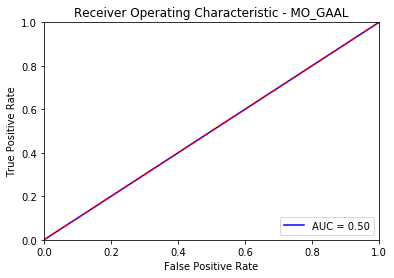

Accuracy:  0.8290666666666666
Precision: -
Recall:  0.0
F1-score: -
Duration:  9480.611604  seconds




In [28]:
#Neural Networks tests
classifiers = {
    'AutoEncoder': AutoEncoder(contamination = outliers_fraction, hidden_neurons = [8, 4, 4, 8], epochs = 15),
    'SO_GAAL': SO_GAAL(contamination = outliers_fraction),
    'MO_GAAL': MO_GAAL(contamination = outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)